# packages and db

In [1]:
import pymongo
import pandas as pd
import datetime
from plotnine import ggplot, geom_line, labs, theme_bw, facet_wrap, facet_grid, theme, aes, geom_point, scale_color_brewer,\
    geom_histogram, geom_vline, annotate
import warnings
from IPython.display import HTML

warnings.filterwarnings('ignore')

myclient = pymongo.MongoClient('mongodb://localhost:27017')
scrapedb = myclient['scrapedb']
adcollection = scrapedb['ads']
adcollection_d = scrapedb['ads_deduplicated']

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# precalculations

In [3]:
# vary basic handling of outliers
# price
adcollection.update_many(
	{'$or':[{'properties.Cena':{'$lt':30000}}, {'properties.Cena':{'$gt':900000}}]},
	{'$set':{'properties.Cena':170000}},
	upsert=False
)

# price m2
adcollection.update_many(
	{'properties.Cena za meter':{'$gt':10000}},
	{'$set':{'properties.Cena za meter':3000}},
	upsert=False
)

# size
adcollection.update_many(
	{'properties.Úžitková plocha':{'$lt':10}},
	{'$set':{'properties.Úžitková plocha':40}},
	upsert=False
)


# refresh collection without duplicates - take only the last one if scraped multiple times
adcollection.aggregate([
	{'$sort':{'scraped timestamp':1}},
	{'$group':{
		'_id':'$properties.link',
		'ad':{'$last':'$$ROOT'}
		}
	},
	{'$replaceRoot':{'newRoot':'$ad'}},
	{'$out':'ads_deduplicated'}

	])

locs = ['Bratislava I, Staré Mesto',
'Bratislava II, Ružinov',
'Bratislava V, Petržalka',
'Bratislava III, Nové Mesto',
'Bratislava IV, Dúbravka',
'Bratislava IV, Karlova Ves',
'Bratislava II, Vrakuňa',
'Bratislava III, Rača',
'Bratislava II, Podunajské Biskupice',
'Bratislava IV, Devínska Nová Ves',
'Bratislava V, Jarovce',
'Bratislava IV, Lamač']

# date filter for overall stats

In [4]:
start = datetime.datetime(2020, 5, 10, 0, 0, 0)
end = datetime.datetime.now()

In [5]:
q0 = list(adcollection.aggregate([
	{'$group':{'_id':'global',
			'scraped_date_min':{'$min':'$scraped timestamp'}
		}
  
  }
	
]))[0]['scraped_date_min']
	
print(f"First item scraped: {q0}")

First item scraped: 2020-05-10 13:28:57.405000


In [6]:
q0 = list(adcollection.aggregate([
	{'$group':{'_id':'global',
			'scraped_date_max':{'$max':'$scraped timestamp'}
		}
  
  }
	
]))[0]['scraped_date_max']
	
print(f"Last item scraped: {q0}")

Last item scraped: 2020-07-26 18:53:08.109000


# COUNTS

## number of all documents

In [7]:
q1 = adcollection.count_documents({'scraped timestamp': {'$lt': end, '$gte': start}})
print(f"Number of all documents: {q1}")

Number of all documents: 19383


## number of scraped documents per week

In [8]:
q2 = list(adcollection.aggregate([
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            }
                }
    },
    {'$group':{'_id':'$yearweek', 'scraped_documents_count':{'$sum':1}}}
    
    
]))

df2 = pd.json_normalize(q2)\
    .rename(columns = {'_id':'yearweek'})\
    .sort_values('yearweek')
df3 = df2.set_index('yearweek')
df3.T

yearweek                 202019  202020  202021  202022  202023  202024  \
scraped_documents_count     312     305     800    1594    1597    1595   

yearweek                 202025  202026  202027  202028  202029  202030  
scraped_documents_count    1592    1597    1598    1598    3376    3419

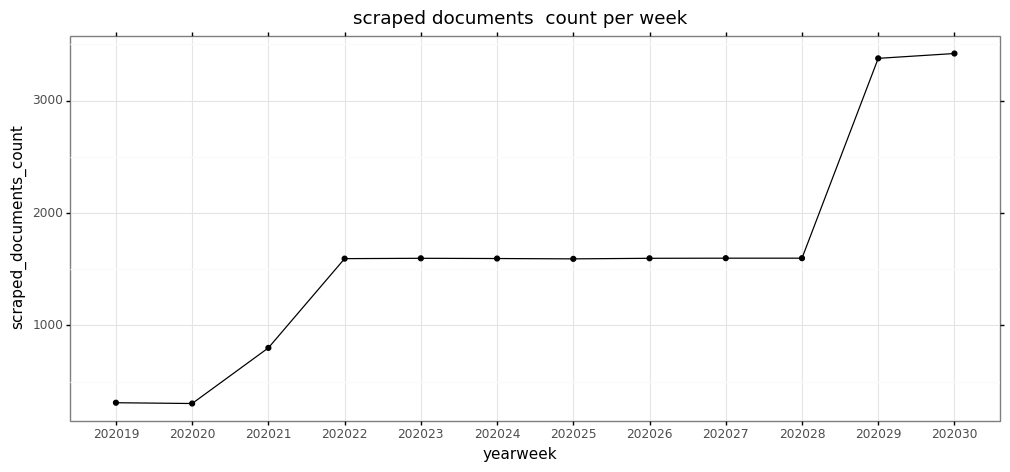

<ggplot: (-9223371870582255280)>


In [9]:
p = (ggplot(aes(x = 'yearweek', y = 'scraped_documents_count', group = 1), data = df2)
    + geom_line()
    + geom_point()
    + labs(title = 'scraped documents  count per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

## number of distinct ads

In [10]:
q3 = len(adcollection.distinct('properties.link'))
print(f"Number of distinct ads: {q3}")

Number of distinct ads: 7211


## number of ads with tags

In [11]:
q4 = adcollection_d.count_documents({'tags.1':{'$exists':True}, 'scraped timestamp': {'$lt': end, '$gte': start}})
print(f"Number of ads with atleast 1 tag: {q4}")

Number of ads with atleast 1 tag: 3181


In [12]:
q4_0 = list(adcollection.aggregate([    
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            },
                'tags':1}
    },
    {'$match':{'tags.1':{'$exists':True}}},
    {'$group':{'_id':'$yearweek', 'documents_count':{'$sum':1}}}
    
    
]))

df4_0 = pd.json_normalize(q4_0)\
    .rename(columns = {'_id':'yearweek', 'documents_count':'ads_with_tags_count'})\
    .sort_values('yearweek')
df4_0.pivot_table(columns = 'yearweek')

yearweek             202019  202020  202021  202022  202023  202024  202025  \
ads_with_tags_count     121     109     344     689     746     744     700   

yearweek             202026  202027  202028  202029  202030  
ads_with_tags_count     705     682     652    1334    1379

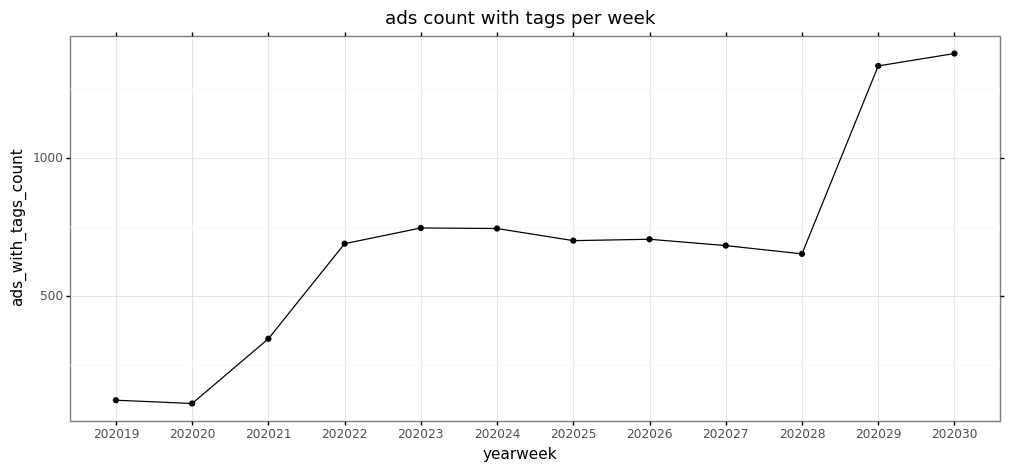

<ggplot: (-9223371870581814920)>


In [13]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_with_tags_count', group = 1), data = df4_0)
    + geom_line()
    + geom_point()
    + labs(title = 'ads count with tags per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

## counts of tags

In [14]:
q4_2 = list(adcollection.aggregate([
    {'$match': {'scraped timestamp': {'$lt': end, '$gte': start}}},
        {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            },
                'tags':1}
    },
	{'$unwind':'$tags'},
	{'$group':{'_id':{'yearweek':'$yearweek', 'tags':'$tags'}, 'tag_count':{'$sum':1}
		}
  
  }
	
]))
	
df4_2 = pd.json_normalize(q4_2)\
    .rename(columns = {'_id.tags':'tag', '_id.yearweek':'yearweek'})\
    .sort_values('tag_count', ascending = False)

df4_3 = df4_2.pivot_table(columns = 'yearweek', index = 'tag', values = 'tag_count')
df4_3['total'] = df4_3.sum(axis = 1)
df4_3 = df4_3.sort_values(by = 'total', ascending = False)

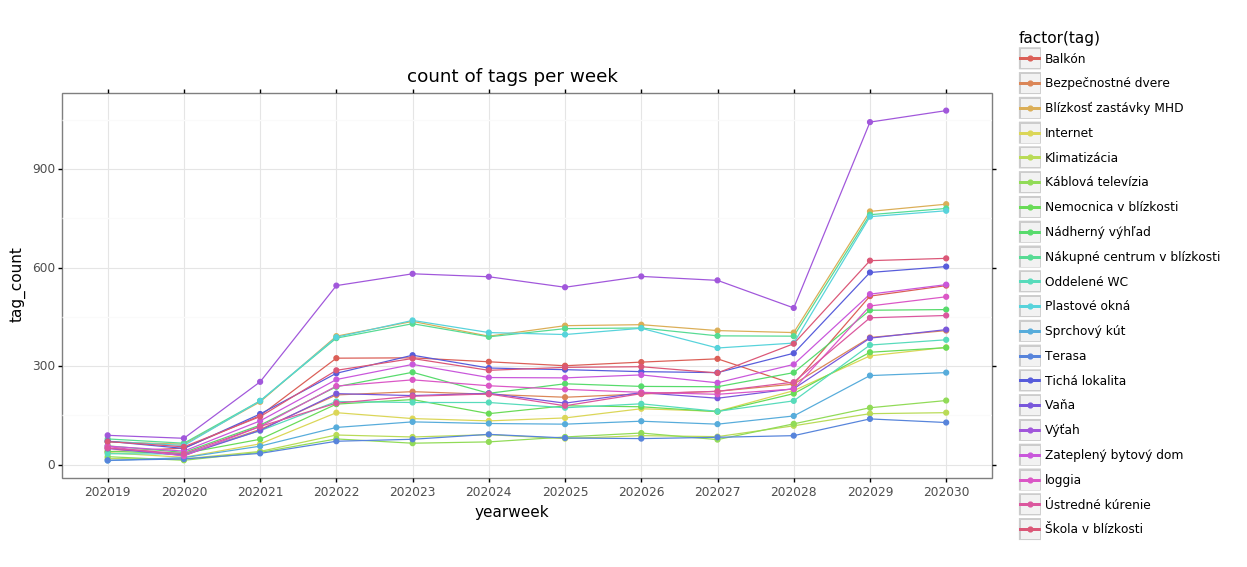

<ggplot: (-9223371870581997340)>


In [15]:
p = (ggplot(aes(x = 'yearweek', y = 'tag_count', color = 'factor(tag)', group = 'factor(tag)'), data = df4_2.loc[df4_2['tag'].isin(list(df4_3.index[:20])),:])
    + geom_line()
    + geom_point()
    + labs(title = 'count of tags per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

In [16]:
df4_3.head(20).style.format("{:.0f}")

In [17]:
q4_1 = list(adcollection_d.aggregate([
    {'$match': {'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$unwind':'$tags'},
	{'$group':{'_id':'$tags', 'tag_count':{'$sum':1}
		}
  
  }
	
]))
	
df4_1 = pd.json_normalize(q4_1)\
    .rename(columns = {'_id':'tag'})\
    .sort_values('tag_count', ascending = False)
df4_1.head(20)

tag  tag_count
27                        Výťah       2427
43        Blízkosť zastávky MHD       1984
85                Plastové okná       1965
39  Nákupné centrum v blízkosti       1950
29            Škola v blízkosti       1728
3                Tichá lokalita       1625
50         Zateplený bytový dom       1495
13              Nádherný výhľad       1330
1                        loggia       1314
63                       Balkón       1170
52        Nemocnica v blízkosti       1055
20             Ústredné kúrenie       1040
0                          Vaňa       1028
4            Bezpečnostné dvere        966
34                  Oddelené WC        953
70                     Internet        824
78                 Sprchový kút        625
18            Káblová televízia        475
60                 Klimatizácia        343
94          Lokálne vykurovanie        329

## number of ads with map coordinates

In [18]:
q5 = adcollection_d.count_documents({'mapcoord.lon':{'$exists':True}, 'scraped timestamp': {'$lt': end, '$gte': start}})
print(f"Number of ads with map coordinates: {q5}")

Number of ads with map coordinates: 6338


In [19]:
q5_1 = list(adcollection.aggregate([
    {'$match': {'scraped timestamp': {'$lt': end, '$gte': start}}},
        {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            },
                'mapcoord':1}
    },
	{'$group':{'_id':'$yearweek', 'with_mapcoord_count':{'$sum':1}
		}
  
  }
	
]))
	
df5_1 = pd.json_normalize(q5_1)\
    .rename(columns = {'_id':'yearweek'})
df5_2 = df5_1.pivot_table(columns = 'yearweek')
df5_2['total'] = df5_2.sum(axis = 1)
df5_2

yearweek             202019  202020  202021  202022  202023  202024  202025  \
with_mapcoord_count     312     305     800    1594    1597    1595    1592   

yearweek             202026  202027  202028  202029  202030  total  
with_mapcoord_count    1597    1598    1598    3376    3419  19383

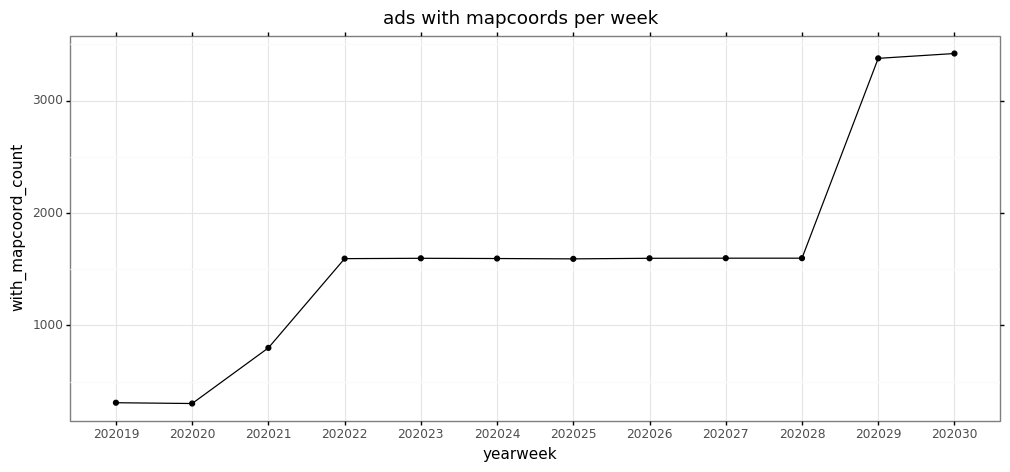

<ggplot: (-9223371870580366760)>


In [20]:
p = (ggplot(aes(x = 'yearweek', y = 'with_mapcoord_count', group = 1), data = df5_1)
    + geom_line()
    + geom_point()
    + labs(title = 'ads with mapcoords per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

## counts of keys in properties

In [21]:
q5_1 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$project':{
		'properties':{'$objectToArray':'$properties'}
		}
  
  },
	{'$unwind':'$properties'},
	{'$group':{'_id':'$properties.k',
			'ads_count':{'$sum':1}
		}
  
  }
	
]))
	
df5_1 = pd.json_normalize(q5_1)\
    .rename(columns = {'_id':'property'})\
    .sort_values('ads_count', ascending = False)
df5_1

property  ads_count
11                  link       7211
10          Aktualizácia       7211
17               Pivnica       7211
16              Lokalita       7211
15             Kategória       7211
21          Cena dohodou       7211
2        Balkón / loggia       7211
9        Úžitková plocha       7157
8        Provízia v cene       6972
0                   Cena       6972
19         Cena za meter       6907
7                  Ulica       6340
20                 Výťah       5976
1   Identifikačné číslo:       5852
4         Pocet poschodi       5827
18             Poschodie       5827
12                  Stav       5089
3               Materiál       3913
13   Stav nehnuteľnosti:       2134
5       Zastavaná plocha        155
14            Pozemok m2        119
6                 empty1         39

## counts of distinct values in properties

In [22]:
q5_2 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$project':{
		'properties':{'$objectToArray':'$properties'}
		}
  
  },
	{'$unwind':'$properties'},
	{'$group':{'_id':'$properties.k',
			'unique_values':{'$addToSet': "$properties.v"}
		}
    },
     {'$project':{'_id':1,
                 'unique_values_count':{'$size':'$unique_values'}}
     
     }
  

	
]))
	
df5_2 = pd.json_normalize(q5_2)\
    .rename(columns = {'_id':'property'})\
    .sort_values('unique_values_count', ascending = False)
df5_2

property  unique_values_count
12                  link                 7211
0   Identifikačné číslo:                 5125
11          Aktualizácia                 3442
5          Cena za meter                 2059
21                  Cena                 1301
14                 Ulica                  943
13       Úžitková plocha                  235
16      Zastavaná plocha                   86
9             Pozemok m2                   81
3               Lokalita                   72
18        Pocet poschodi                   33
8              Poschodie                   27
17                empty1                   17
6              Kategória                   10
20              Materiál                    5
10                  Stav                    4
15       Provízia v cene                    3
1                  Výťah                    2
4                Pivnica                    2
19       Balkón / loggia                    2
2           Cena dohodou                    2
7    Stav nehnuteľnosti:                    1

## number of ads per flat category

In [23]:
q6 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                               {'$toString':{'$week':'$scraped timestamp'}}]
                    },
        'properties':1}
    },
    {'$group':{'_id':{'yearweek':'$yearweek', 'flat_category':'$properties.Kategória'}, 'ads_count':{'$sum':1}}}]))

df6 = pd.json_normalize(q6)\
    .rename(columns = {'_id.yearweek':'yearweek', '_id.flat_category':'flat_category'})\
    .sort_values('ads_count', ascending = False)
df7 = df6.pivot_table(columns = 'yearweek', index = 'flat_category', values = 'ads_count')
df7['total'] = df7.sum(axis = 1)

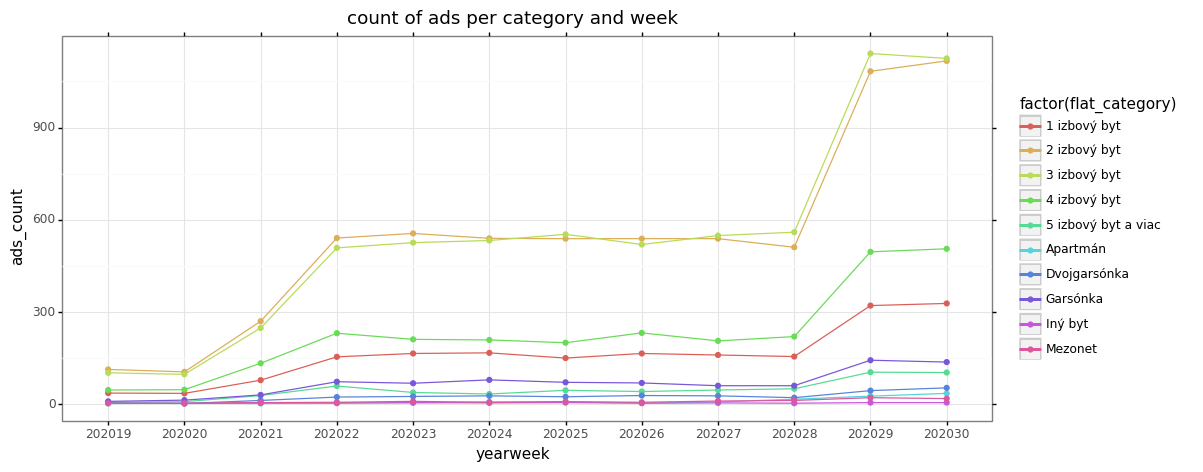

<ggplot: (-9223371870581951732)>


In [24]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_count', color = 'factor(flat_category)', group = 'factor(flat_category)'), 
            data = df6)
    + geom_line()
    + geom_point()
    + labs(title = 'count of ads per category and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

In [25]:
df7.style.format("{:.0f}")

In [26]:
q6_1 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$group':{'_id':'$properties.Kategória', 'ads_count':{'$sum':1}}}]))

df6_1 = pd.json_normalize(q6_1)\
    .rename(columns = {'_id':'flat_category'})\
    .sort_values('ads_count', ascending = False)
df6_1

flat_category  ads_count
0         3 izbový byt       2446
8         2 izbový byt       2420
1         4 izbový byt        938
5         1 izbový byt        739
2             Garsónka        314
9  5 izbový byt a viac        159
3         Dvojgarsónka        117
7             Apartmán         44
4              Mezonet         28
6              Iný byt          6

## number of ads per state and category

In [27]:
q8 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                           {'$toString':{'$week':'$scraped timestamp'}}]
                },
    'properties':1}
    },
    {'$group':{'_id':{'yearweek':'$yearweek', 'kategoria':'$properties.Kategória', 'stav':'$properties.Stav'}, 'ads_count':{'$sum':1}}}]))

df8 = pd.json_normalize(q8)\
    .rename(columns = {'_id.kategoria':'category', '_id.stav':'state', '_id.yearweek':'yearweek'})\
    .sort_values(['state', 'ads_count'], ascending = False)
df8 = df8[['state', 'category', 'yearweek','ads_count']]
df9 = df8.pivot_table(index=['category','state'], columns='yearweek', values='ads_count')
df9['total'] = df9.sum(axis = 1)

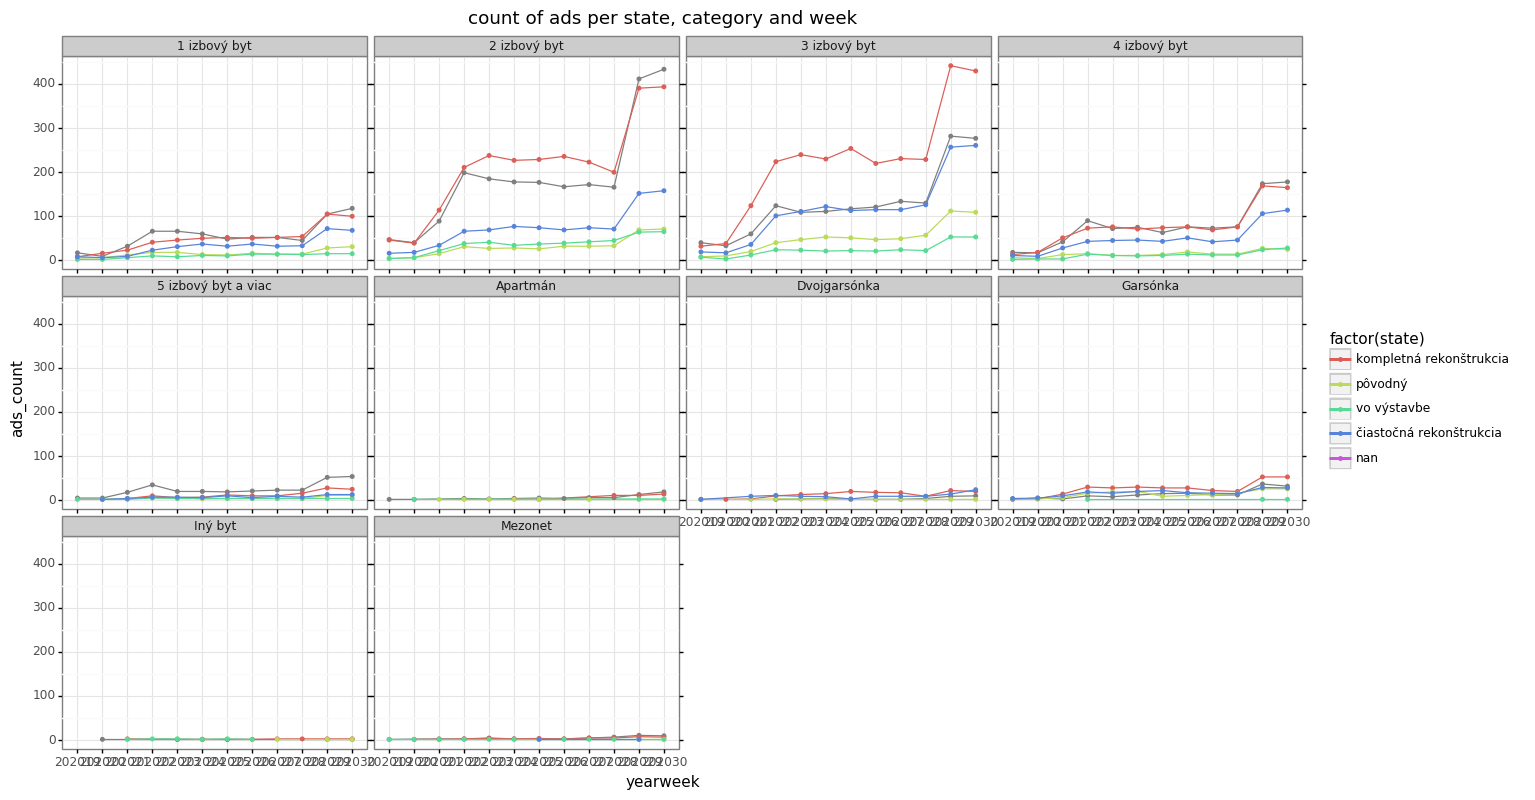

<ggplot: (-9223371870580032936)>


In [28]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_count', color = 'factor(state)', group = 'factor(state)'), 
            data = df8)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'count of ads per state, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [29]:
df9.style.format("{:.0f}", na_rep = '-')

In [30]:
q8 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$group':{'_id':{'kategoria':'$properties.Kategória', 'stav':'$properties.Stav'}, 'ads_count':{'$sum':1}}}]))

df8 = pd.json_normalize(q8)\
    .rename(columns = {'_id.kategoria':'category', '_id.stav':'state'})\
    .sort_values(['state', 'ads_count'], ascending = False)
df8 = df8[['state', 'category', 'ads_count']]
df8 = df8.pivot(index='state', columns='category', values='ads_count')
df8['state_count'] = df8.sum(axis = 1)
df8 = df8.sort_values('state_count', ascending = False)
df8.style.format("{:.0f}", na_rep = '-')

## number of ads per location and category

### counts

In [31]:
q10 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$group':{'_id':{'kategoria':'$properties.Kategória', 'lokalita':'$properties.Lokalita'}, 'ads_count':{'$sum':1}}}]))

df10 = pd.json_normalize(q10)\
    .rename(columns = {'_id.kategoria':'category', '_id.lokalita':'location'})
df10 = df10.pivot(index='location', columns='category', values='ads_count')
df10['location_count'] = df10.sum(axis = 1)
df10 = df10.sort_values('location_count', ascending = False)
df10.head(30).style.format("{:.0f}", na_rep = '-')

### percent

In [32]:
df11 = df10.iloc[:,[i for i in range(0, 10)]].apply(lambda x: x/df10['location_count'])
df11.head(30).style.format("{:.2%}", na_rep = '-')

### mean percent of category in top few locations

In [33]:
df11.loc[locs,:].mean().to_frame().style.format("{:.2%}")


## counts per yearweek

In [34]:
q8 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                           {'$toString':{'$week':'$scraped timestamp'}}]
                },
    'properties':1}
    },
    {'$group':{'_id':{'yearweek':'$yearweek', 'kategoria':'$properties.Kategória', 'location':'$properties.Lokalita'}, 'ads_count':{'$sum':1}}}]))

df8 = pd.json_normalize(q8)\
    .rename(columns = {'_id.kategoria':'category', '_id.location':'location', '_id.yearweek':'yearweek'})
df8 = df8[['location', 'category', 'yearweek','ads_count']]
df8 = df8.loc[df8['location'].isin(locs),:]
df9 = df8.pivot_table(index=['category','location'], columns='yearweek', values='ads_count')
df9['total'] = df9.sum(axis = 1)

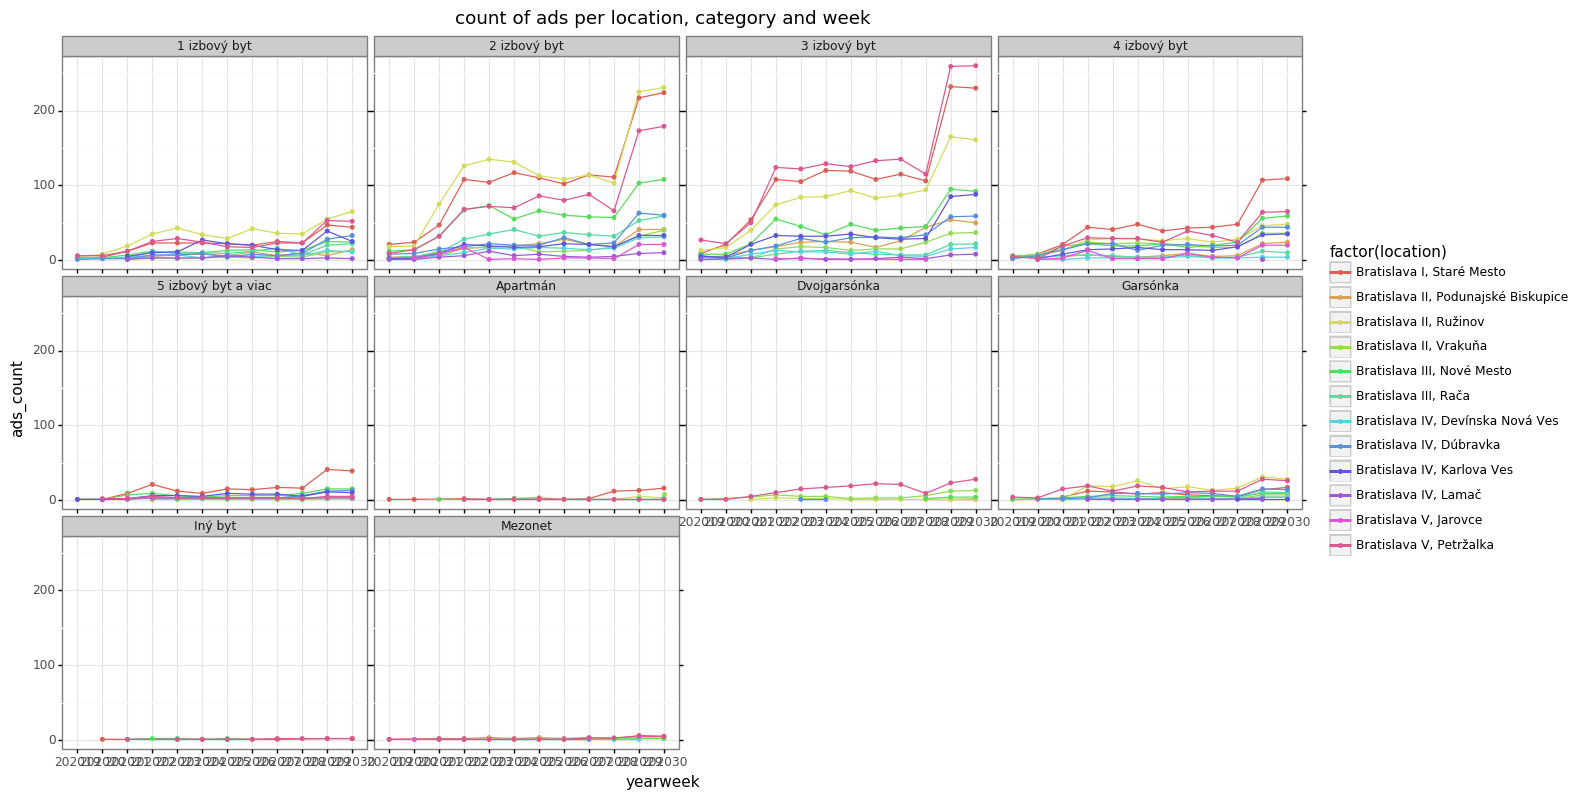

<ggplot: (-9223371870581840372)>


In [35]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_count', color = 'factor(location)', group = 'factor(location)'), 
            data = df8)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'count of ads per location, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [36]:
df9.style.format("{:.0f}", na_rep = '-')

# AVG PRICE

In [37]:
q12 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':'global',
			'price_avg':{'$avg':'$properties.Cena'}
		}
  
  }
	
]))[0]['price_avg']

print(f"Average price of whole set: {q12}")

Average price of whole set: 194641.39988525532


In [38]:
q12 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                       {'$toString':{'$week':'$scraped timestamp'}}]
            },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek'},
			'price_avg':{'$avg':'$properties.Cena'}
		}
  
  }
	
]))
	
df12 = pd.json_normalize(q12)\
    .rename(columns = {'_id.yearweek':'yearweek'})
df13 = df12.pivot_table(columns = 'yearweek')
df13.style.format("{:,.0f}")


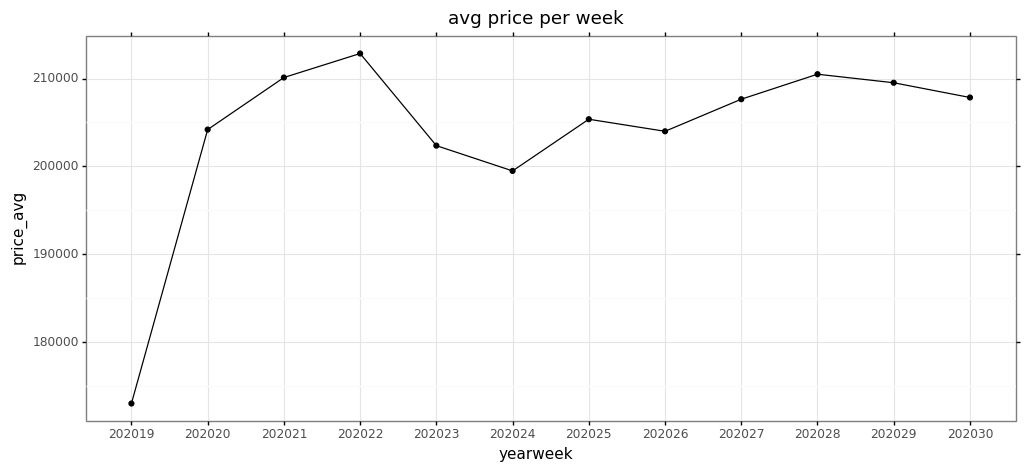

<ggplot: (-9223371870579287752)>


In [39]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', group = 1), 
            data = df12)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg price per category

In [40]:
q13 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                   {'$toString':{'$week':'$scraped timestamp'}}]
        },
    'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category', '_id.yearweek':'yearweek'})\
    .sort_values('price_avg', ascending = False)
df13 = df13[['category', 'yearweek', 'price_avg']]
df14 = df13.pivot_table(columns = 'yearweek', index = 'category', values = 'price_avg')

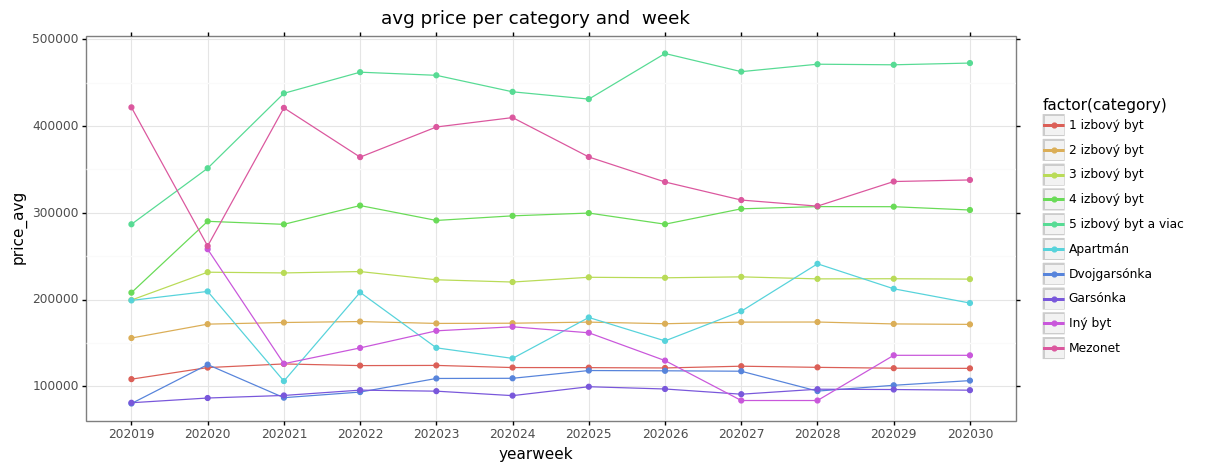

<ggplot: (-9223371870583322516)>


In [41]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(category)', group = 'factor(category)'), 
            data = df13)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per category and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [42]:
df14.style.format("{:,.0f}")

In [43]:
q13 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
            'ads_count':{'$sum':1}}  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category'})\
    .sort_values('price_avg', ascending = False)
df13 = df13[['category', 'price_avg', 'ads_count']]
df13.style.format({'price_avg':"{:,.0f}"})

## avg price per location

In [44]:
q14 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
               {'$toString':{'$week':'$scraped timestamp'}}]
    },
    'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek','location':'$properties.Lokalita'},
			'price_avg':{'$avg':'$properties.Cena'}}  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location', '_id.yearweek':'yearweek'})
df14 = df14.loc[df14['location'].isin(locs), ['location', 'yearweek', 'price_avg']]
df15 = df14.pivot_table(columns = 'yearweek', index = 'location', values = 'price_avg')

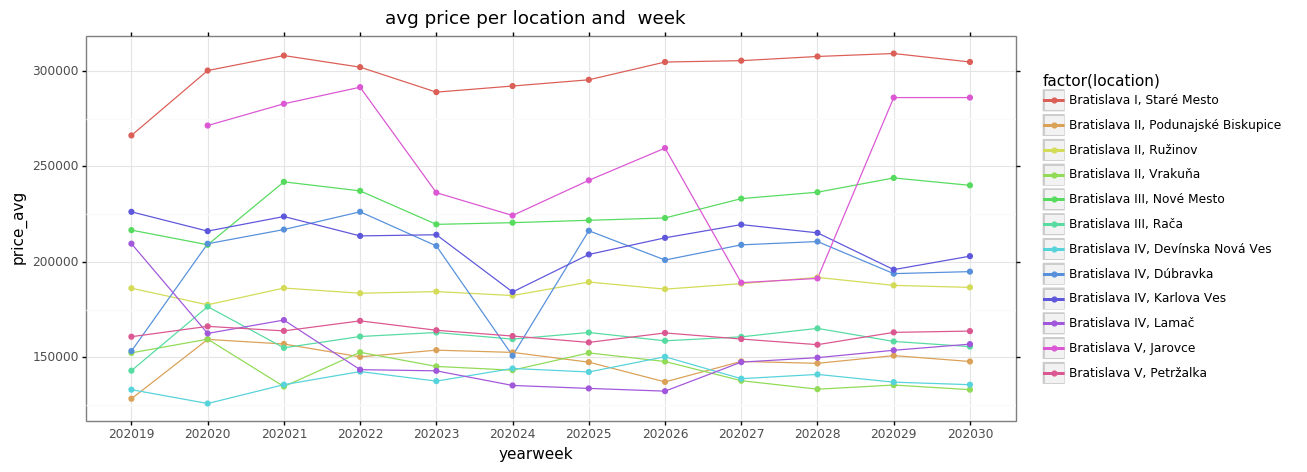

<ggplot: (-9223371870580264784)>


In [45]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df14)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per location and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [46]:
df15.style.format("{:,.0f}")

In [47]:
q14 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location'})\
    .sort_values('price_avg', ascending = False)
df14 = df14[['location', 'price_avg', 'ads_count']]
df15 = df14.loc[df14['location'].isin(locs),:]
df15.style.format({'price_avg':"{:,.0f}"})

## avg price per location and category

In [48]:
q16 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
           {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}  
  }
	
]))
	
df16 = pd.json_normalize(q16)\
    .rename(columns = {'_id.location':'location', '_id.category':'category', '_id.yearweek':'yearweek'})\
    .sort_values('price_avg', ascending = False)
df16 = df16.loc[df16['location'].isin(locs), ['location', 'yearweek', 'category', 'price_avg']]
df17 = df16.pivot_table(columns = 'yearweek', index = ['category', 'location'], values = 'price_avg')

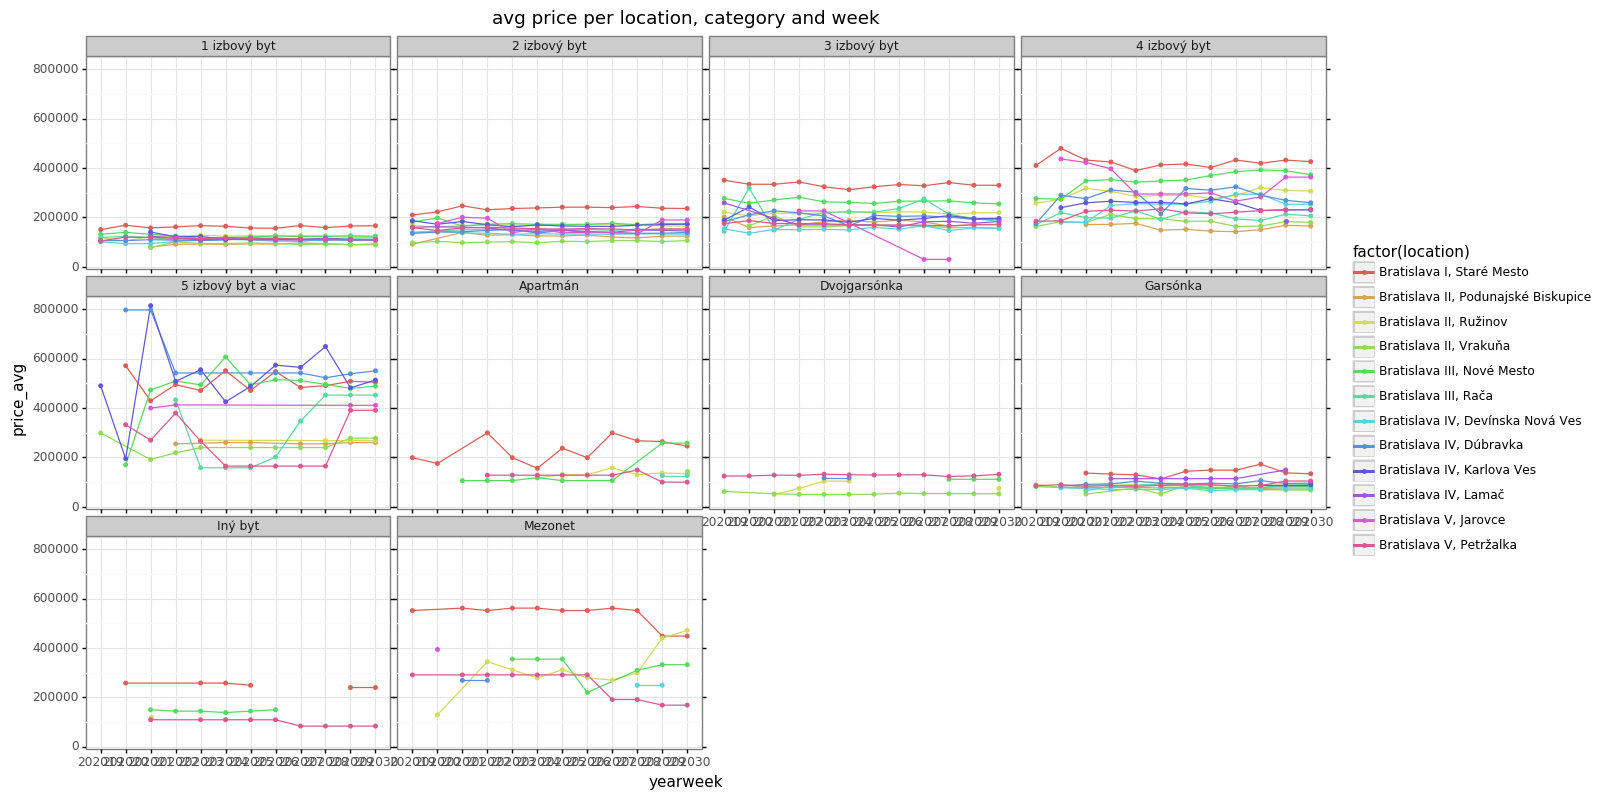

<ggplot: (-9223371870579489872)>


In [49]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg price per location, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [50]:
df17.style.format("{:,.0f}", na_rep = '-')

In [51]:
q17 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}  
  }
	
]))
	
df17 = pd.json_normalize(q17)\
    .rename(columns = {'_id.location':'location', '_id.category':'category'})\
    .sort_values('price_avg', ascending = False)
df17 = df17[['location', 'category', 'price_avg', 'ads_count']]
df17.loc[df17['location'].isin(locs),:]
df18 = df17.loc[df17['location'].isin(locs),:].pivot(index='location', columns='category', values='price_avg')
df18.style.format("{:,.0f}", na_rep = '-')

### 2 room apartment

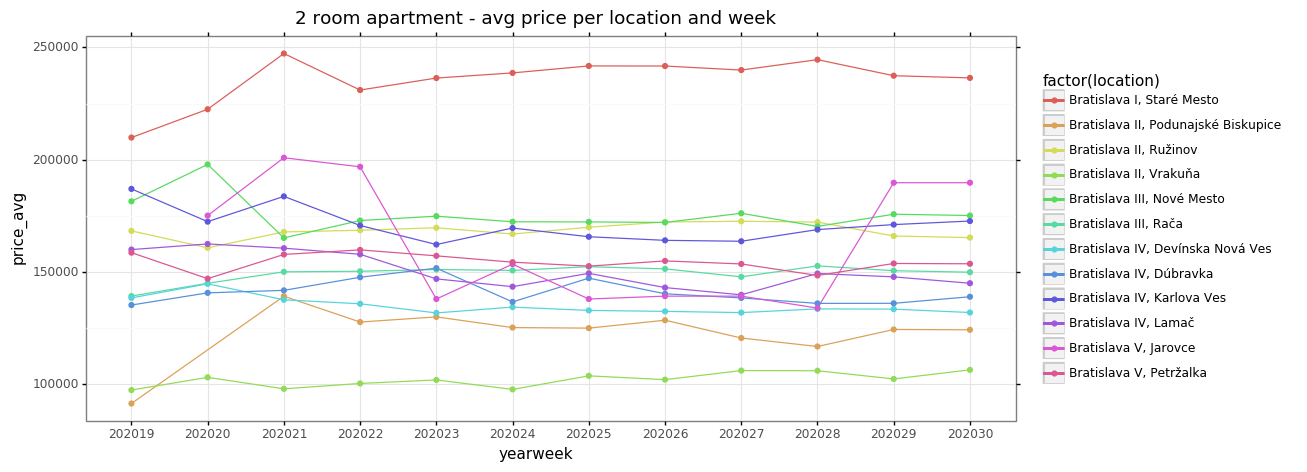

<ggplot: (-9223371870580121932)>


In [52]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '2 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '2 room apartment - avg price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

### 3 room apartment

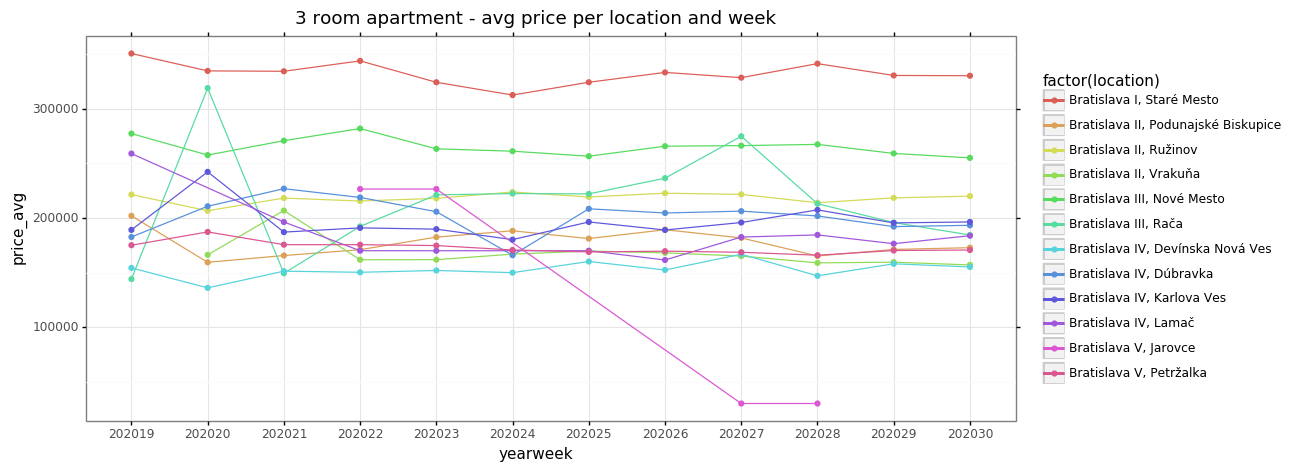

<ggplot: (-9223371870580105452)>


In [53]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '3 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '3 room apartment - avg price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg price per state

In [54]:
q18 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'}}
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state', '_id.yearweek':'yearweek'})\
    .sort_values('price_avg', ascending = False)
df18 = df18[['state', 'yearweek', 'price_avg']]
df19 = df18.pivot_table(columns = 'yearweek', index = 'state', values = 'price_avg')

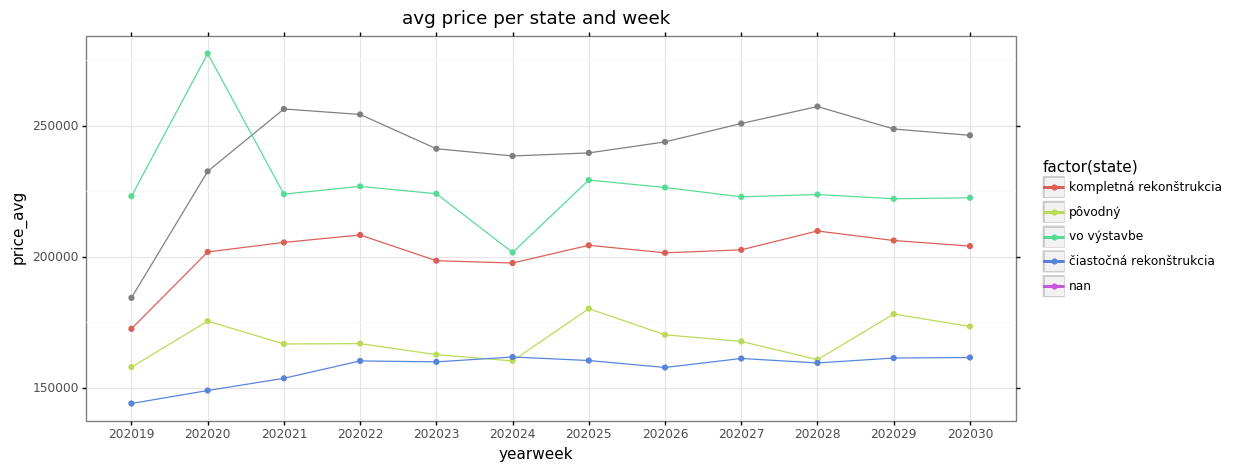

<ggplot: (-9223371870579179688)>


In [55]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df18)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [56]:
df19.style.format("{:,.0f}")

In [57]:
q18 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state'})\
    .sort_values('price_avg', ascending = False)
df18 = df18[['state', 'price_avg', 'ads_count']]
df18.style.format({'price_avg':"{:,.0f}"})

## avg price per state and category

In [58]:
q19 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}
		
  
  }
	
]))
	
df19 = pd.json_normalize(q19)\
    .rename(columns = {'_id.state':'state', '_id.category':'category', '_id.yearweek':'yearweek'})
df19 = df19[['state', 'category', 'yearweek', 'price_avg']]
df20 = df19.pivot_table(index = ['state', 'category'], columns = 'yearweek', values = 'price_avg')

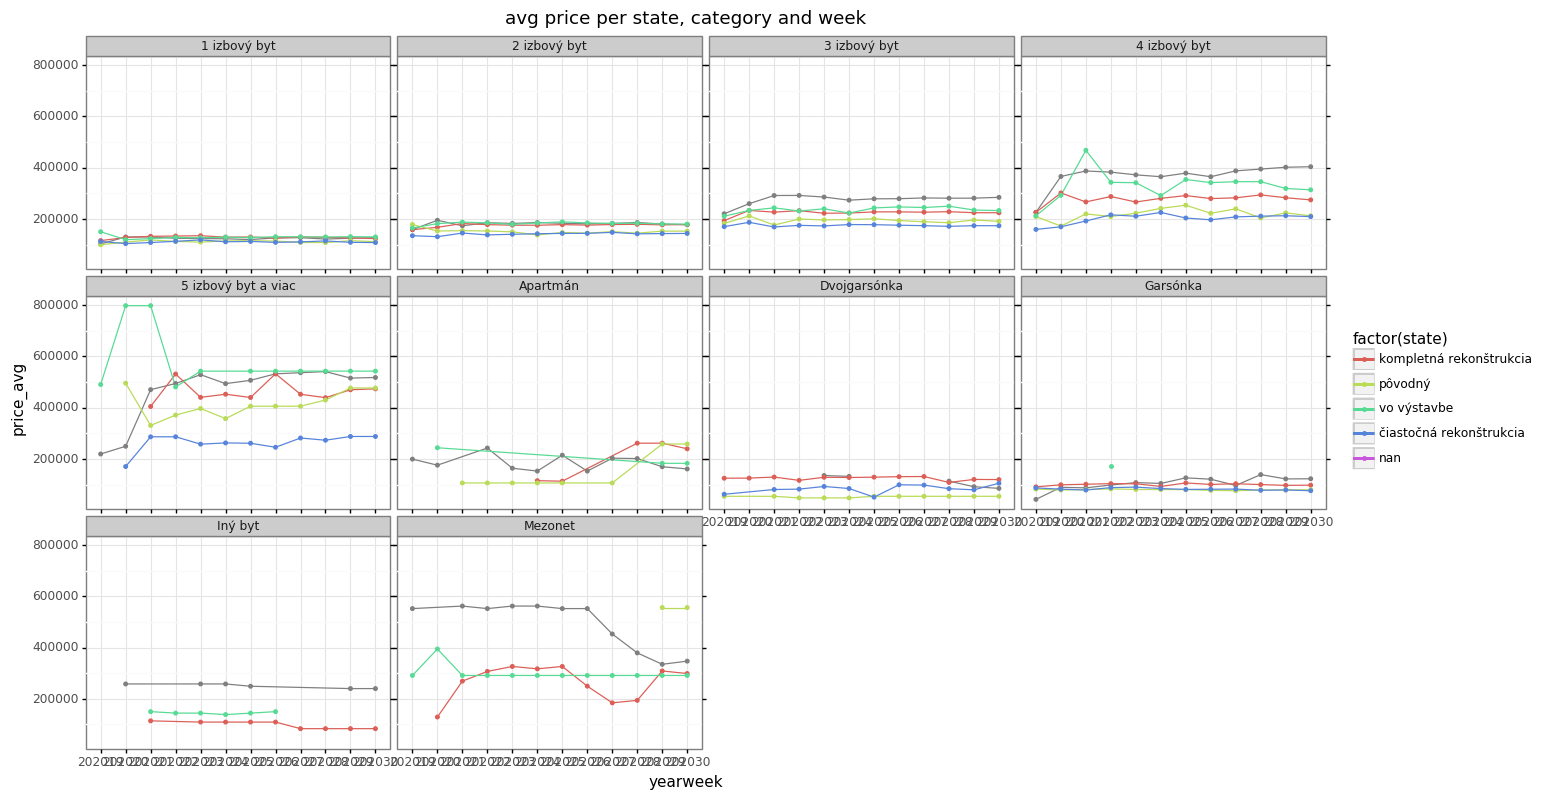

<ggplot: (-9223371870579364884)>


In [59]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg price per state, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [60]:
df20.style.format("{:,.0f}", na_rep = '-')

In [61]:
q20 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.state':'state', '_id.category':'category'})\
    .sort_values(['state', 'price_avg'], ascending = False)
df20 = df20[['state', 'category', 'price_avg', 'ads_count']]
df20 = df20.pivot(index = 'state', columns = 'category', values = 'price_avg')
df20.style.format("{:,.0f}", na_rep = '-')

### 2 room apartment

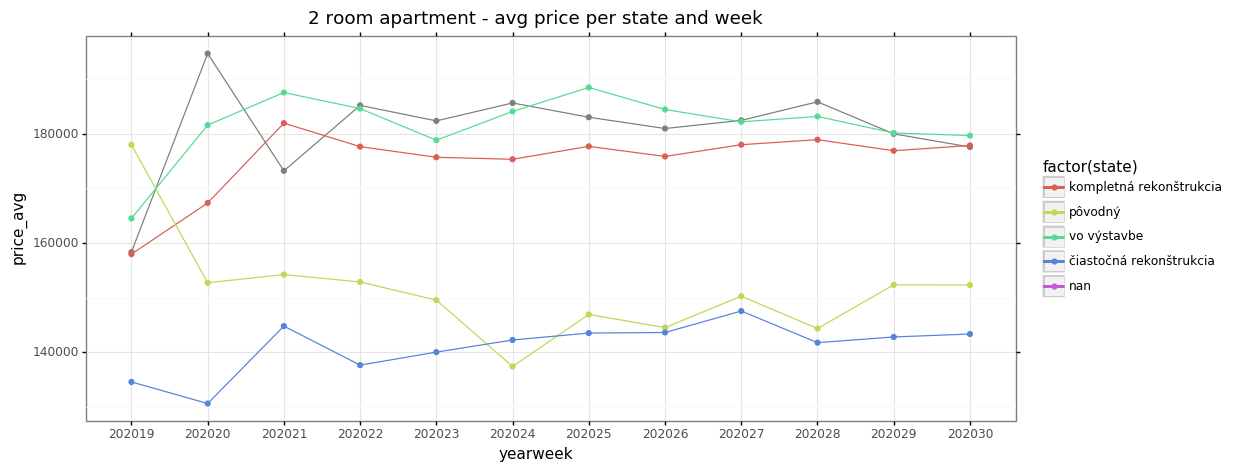

<ggplot: (-9223371870579850992)>


In [62]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19.loc[df19['category'] == '2 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '2 room apartment - avg price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

### 3 room apartment

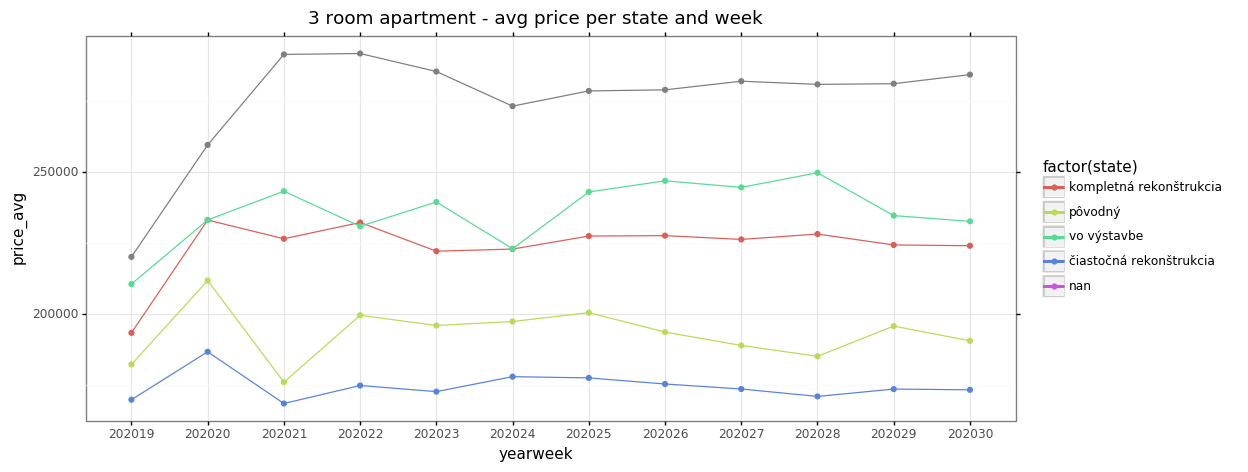

<ggplot: (-9223371870579797976)>


In [63]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19.loc[df19['category'] == '3 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '3 room apartment - avg price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg price per state and location

In [64]:
q20 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
        {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.yearweek':'yearweek'})
df20 = df20[['location', 'yearweek', 'state', 'price_avg']]
df21 = df20.loc[df20['location'].isin(locs),:].pivot_table(index = ['state', 'location'], columns = 'yearweek', values = 'price_avg')

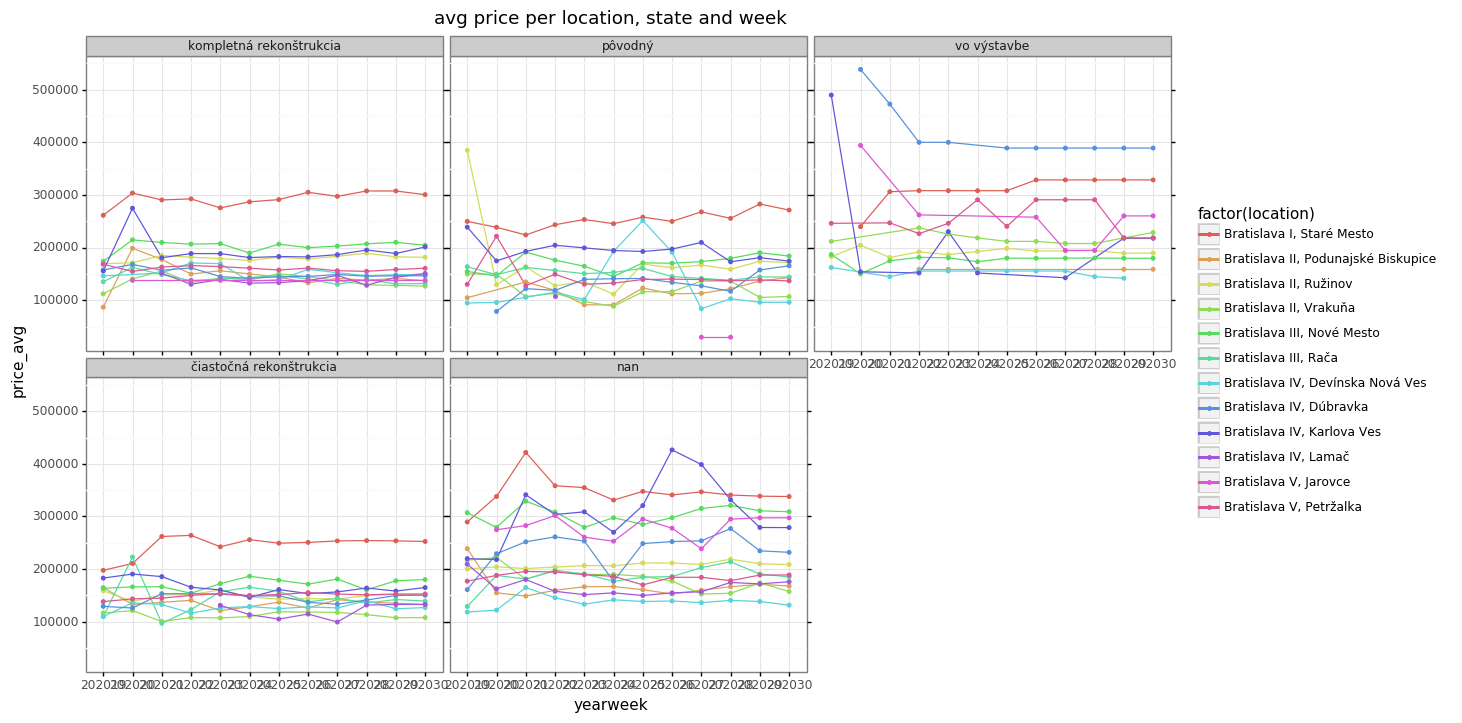

<ggplot: (-9223371870578833340)>


In [65]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df20.loc[df20['location'].isin(locs),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

In [66]:
df21.style.format("{:,.0f}", na_rep = '-')

In [67]:
q20 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state'})\
    .sort_values('price_avg', ascending = False)
df20 = df20[['location', 'state', 'price_avg', 'ads_count']]
df20 = df20.loc[df20['location'].isin(locs),:].pivot(index = 'location', columns = 'state', values = 'price_avg')
df20.style.format("{:,.0f}", na_rep = '-')

## avg price per state, location and category

In [68]:
q21 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}
		
  
  }
	
]))
	
df21 = pd.json_normalize(q21)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category', '_id.yearweek':'yearweek'})
df22 = df21.loc[df21['location'].isin(locs),:].pivot_table(index = ['category', 'state', 'location'], columns = 'yearweek', values = 'price_avg')
df22.style.format("{:,.0f}", na_rep = '-')

In [69]:
q22 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df22 = pd.json_normalize(q22)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category'})\
    .sort_values('price_avg', ascending = False)
df22 = df22.loc[df22['location'].isin(locs),:].pivot_table(index = ['location', 'category'], columns = 'state', values = ['price_avg', 'ads_count'])
df22.columns = df22.columns.swaplevel(0, 1)
df22.sort_index(axis=1, level=0, inplace=True)
df22.style.format("{:,.0f}", na_rep = '-')

### 2 room apartment

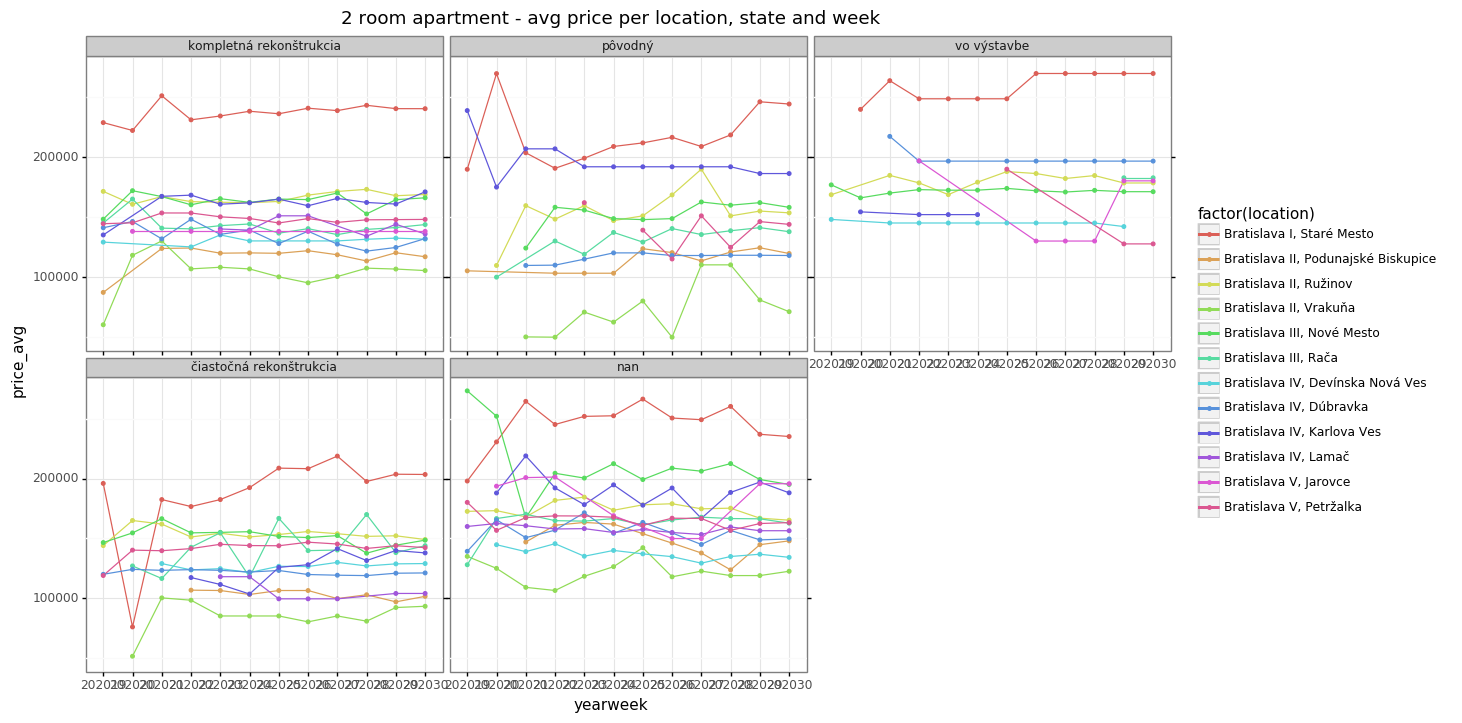

<ggplot: (-9223371870579938044)>


In [70]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '2 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '2 room apartment - avg price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

### 3 room apartment

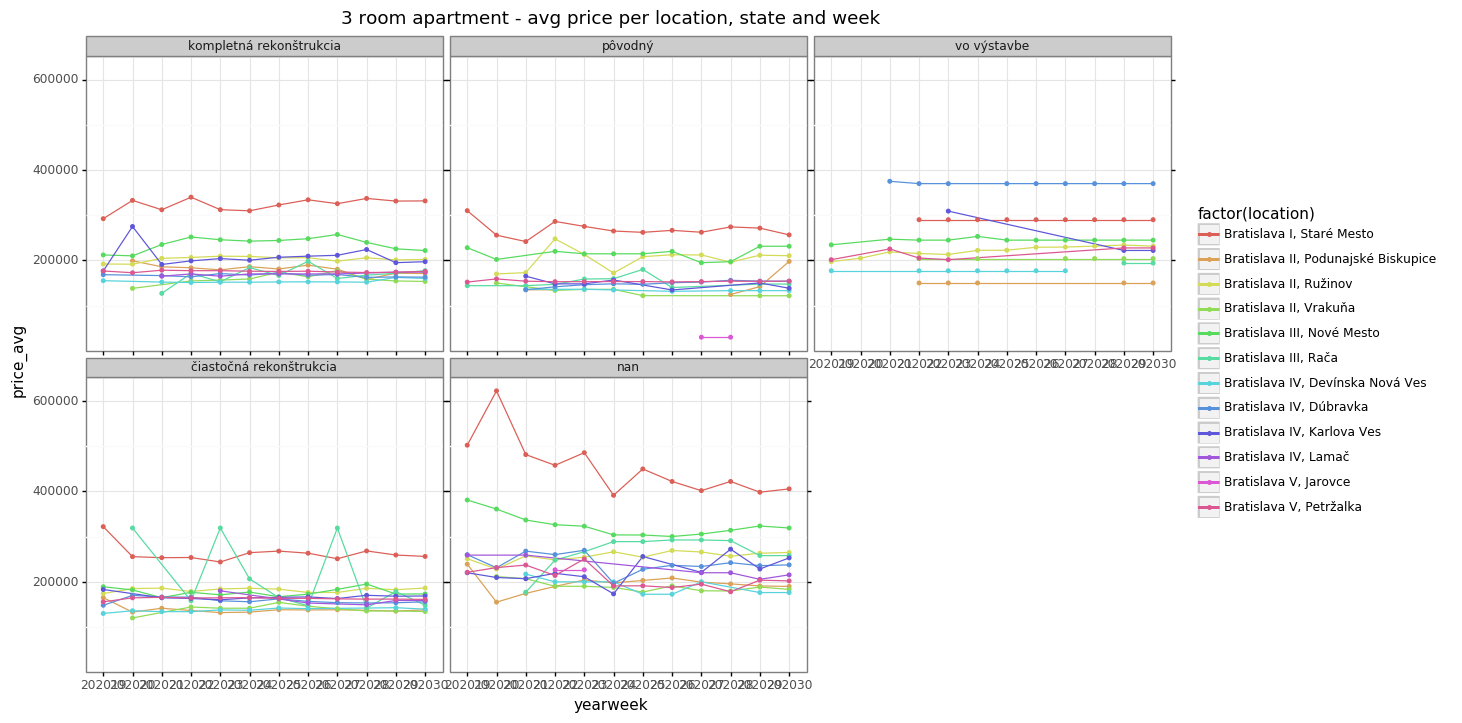

<ggplot: (-9223371870579585528)>


In [71]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '3 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '3 room apartment - avg price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

# AVG M2 PRICE

In [72]:
q12 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':'global',
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}
		}
  
  }
	
]))[0]['price_m2_avg']
	
print(f"Average price of whole set: {q12}")


Average price of whole set: 2911.3767192703053


In [73]:
q12 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':'$yearweek',
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}
		}
  
  }
	
]))
	
df12 = pd.json_normalize(q12)\
    .rename(columns = {'_id':'yearweek'})
df13 = df12.pivot_table(columns = 'yearweek')
df13.style.format("{:.0f}")

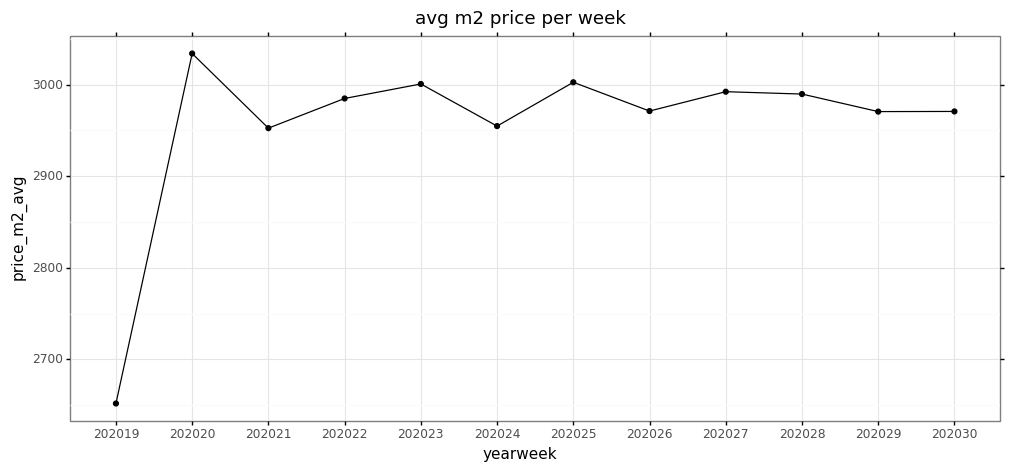

<ggplot: (-9223371870579287292)>


In [74]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', group = 1), 
            data = df12)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg m2 price per category

In [75]:
q13 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category', '_id.yearweek':'yearweek'})
df13 = df13[['category', 'yearweek', 'price_m2_avg']]
df14 = df13.pivot_table(columns = 'yearweek', index = 'category', values = 'price_m2_avg')

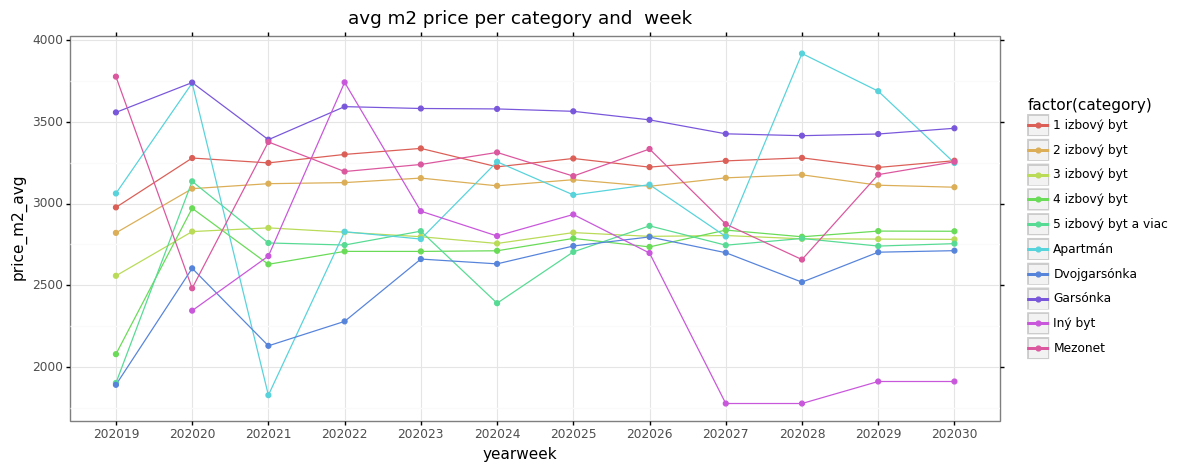

<ggplot: (-9223371870579571280)>


In [76]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(category)', group = 'factor(category)'), 
            data = df13)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per category and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [77]:
df14.style.format("{:.0f}")

In [78]:
q13 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category'})\
    .sort_values('price_m2_avg', ascending = False)
df13 = df13[['category', 'price_m2_avg']]
df13.style.format({'price_m2_avg':"{:.0f}"})

## avg m2 price per location

In [79]:
q14 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location', '_id.yearweek':'yearweek'})
df14 = df14.loc[df14['location'].isin(locs), ['location', 'yearweek','price_m2_avg']]
df15 = df14.pivot_table(columns = 'yearweek', index = 'location', values = 'price_m2_avg')

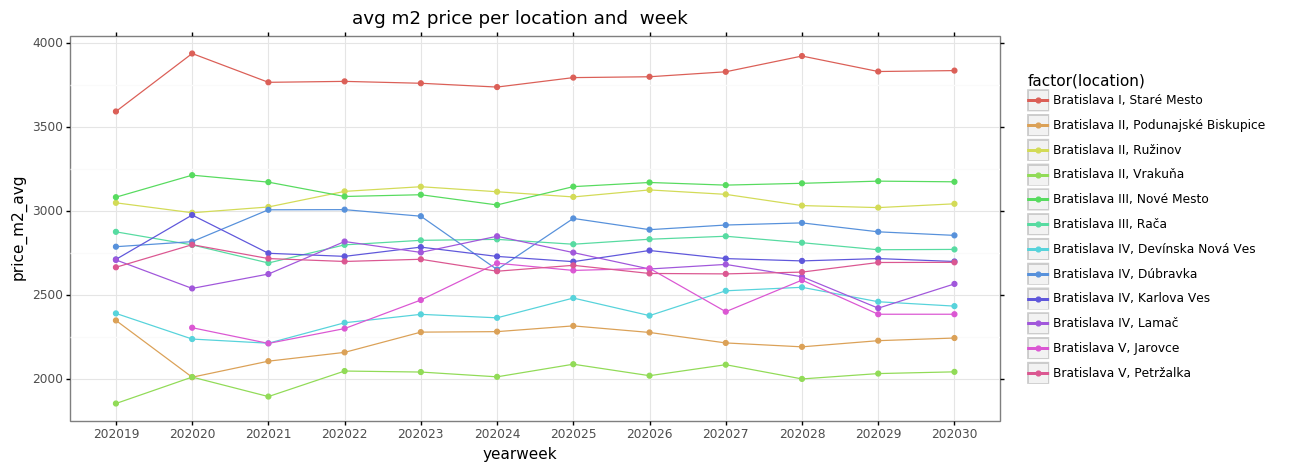

<ggplot: (-9223371870579652160)>


In [80]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df14)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per location and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [81]:
df15.style.format("{:.0f}")

In [82]:
q14 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location'})\
    .sort_values('price_m2_avg', ascending = False)
df14 = df14[['location', 'price_m2_avg', 'ads_count']]
df14.loc[df14['location'].isin(locs),:].style.format({'price_m2_avg':"{:.0f}"})

## avg m2 price per location and category

In [83]:
q16 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}	
  
  }
	
]))
	
df16 = pd.json_normalize(q16)\
    .rename(columns = {'_id.location':'location', '_id.category':'category', '_id.yearweek':'yearweek'})
df16 = df16.loc[df16['location'].isin(locs), ['location', 'category', 'yearweek', 'price_m2_avg']]
df17 = df16.pivot_table(columns = 'yearweek', index = ['category', 'location'], values = 'price_m2_avg')

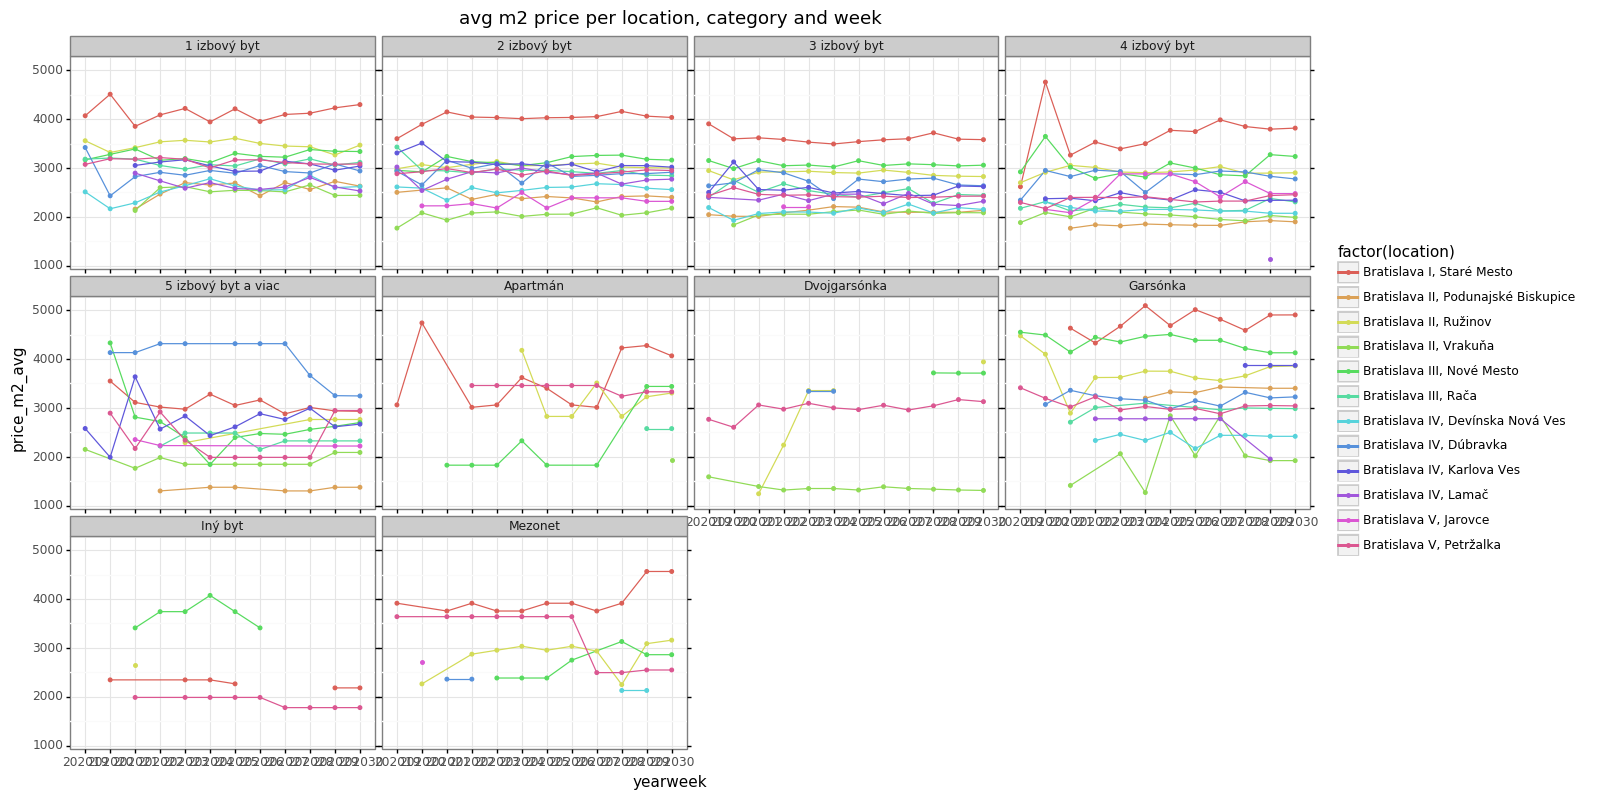

<ggplot: (-9223371870580237732)>


In [84]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg m2 price per location, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [85]:
df17.style.format("{:.0f}", na_rep = '-')

In [86]:
q17 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df17 = pd.json_normalize(q17)\
    .rename(columns = {'_id.location':'location', '_id.category':'category'})\
    .sort_values('price_m2_avg', ascending = False)
df17 = df17[['location', 'category', 'price_m2_avg', 'ads_count']]
df18 = df17.loc[df17['location'].isin(locs),:].pivot(index='location', columns='category', values='price_m2_avg')
df18.style.format("{:.0f}", na_rep = '-')

### 2 room apartment

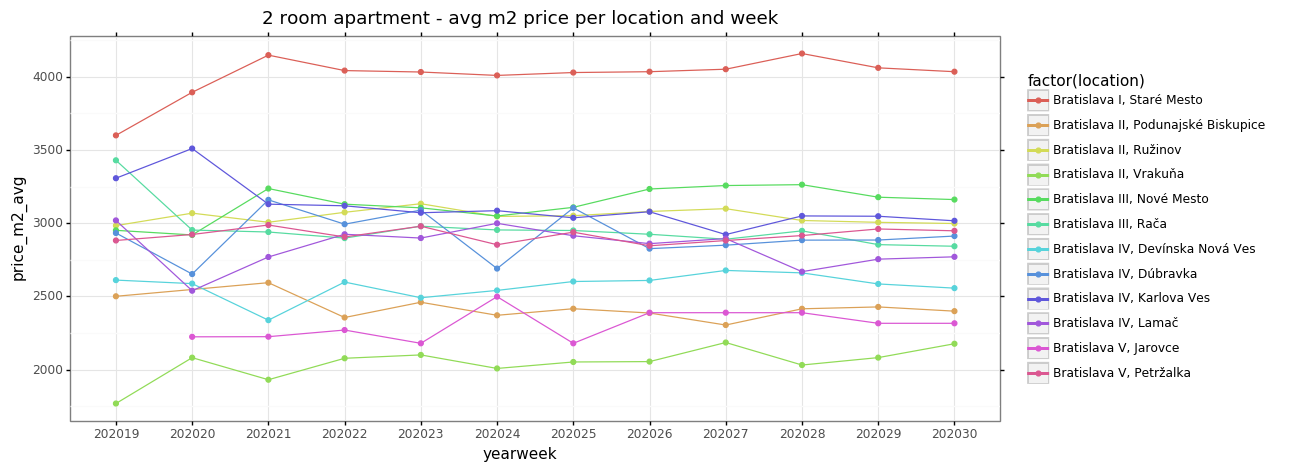

<ggplot: (-9223371870579184364)>


In [87]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '2 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '2 room apartment - avg m2 price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

### 3 room apartment

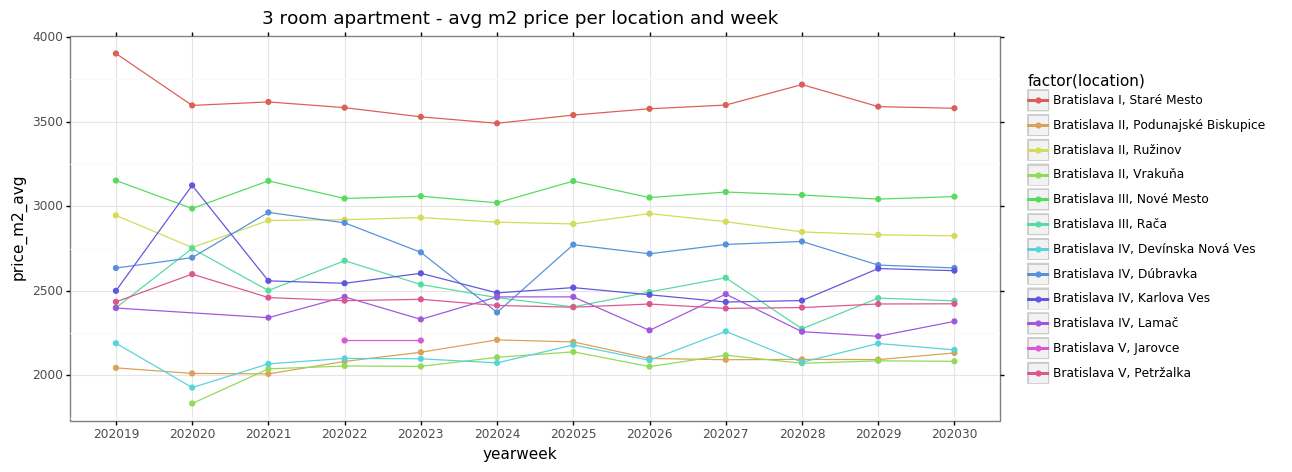

<ggplot: (-9223371870578987672)>


In [88]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '3 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '3 room apartment - avg m2 price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg m2 price per state

In [89]:
q18 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state', '_id.yearweek':'yearweek'})
df18 = df18[['state', 'yearweek', 'price_m2_avg']]
df19 = df18.pivot_table(columns = 'yearweek', index = 'state', values = 'price_m2_avg')

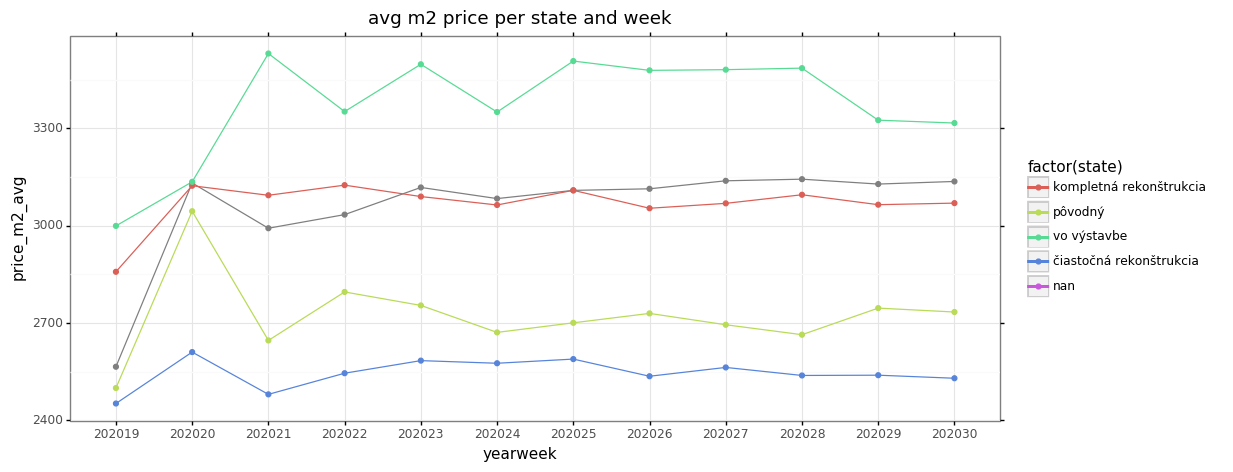

<ggplot: (-9223371870579965084)>


In [90]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df18)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [91]:
df19.style.format("{:.0f}")

In [92]:
q18 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state'})\
    .sort_values('price_m2_avg', ascending = False)
df18 = df18[['state', 'price_m2_avg', 'ads_count']]
df18.style.format({'price_m2_avg':"{:.0f}"})

## avg m2 price per state and category

In [93]:
q19 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df19 = pd.json_normalize(q19)\
    .rename(columns = {'_id.state':'state', '_id.category':'category', '_id.yearweek': 'yearweek'})
df19 = df19[['state', 'category', 'yearweek', 'price_m2_avg']]
df20 = df19.pivot_table(index = ['category', 'state'], columns = 'yearweek', values = 'price_m2_avg')

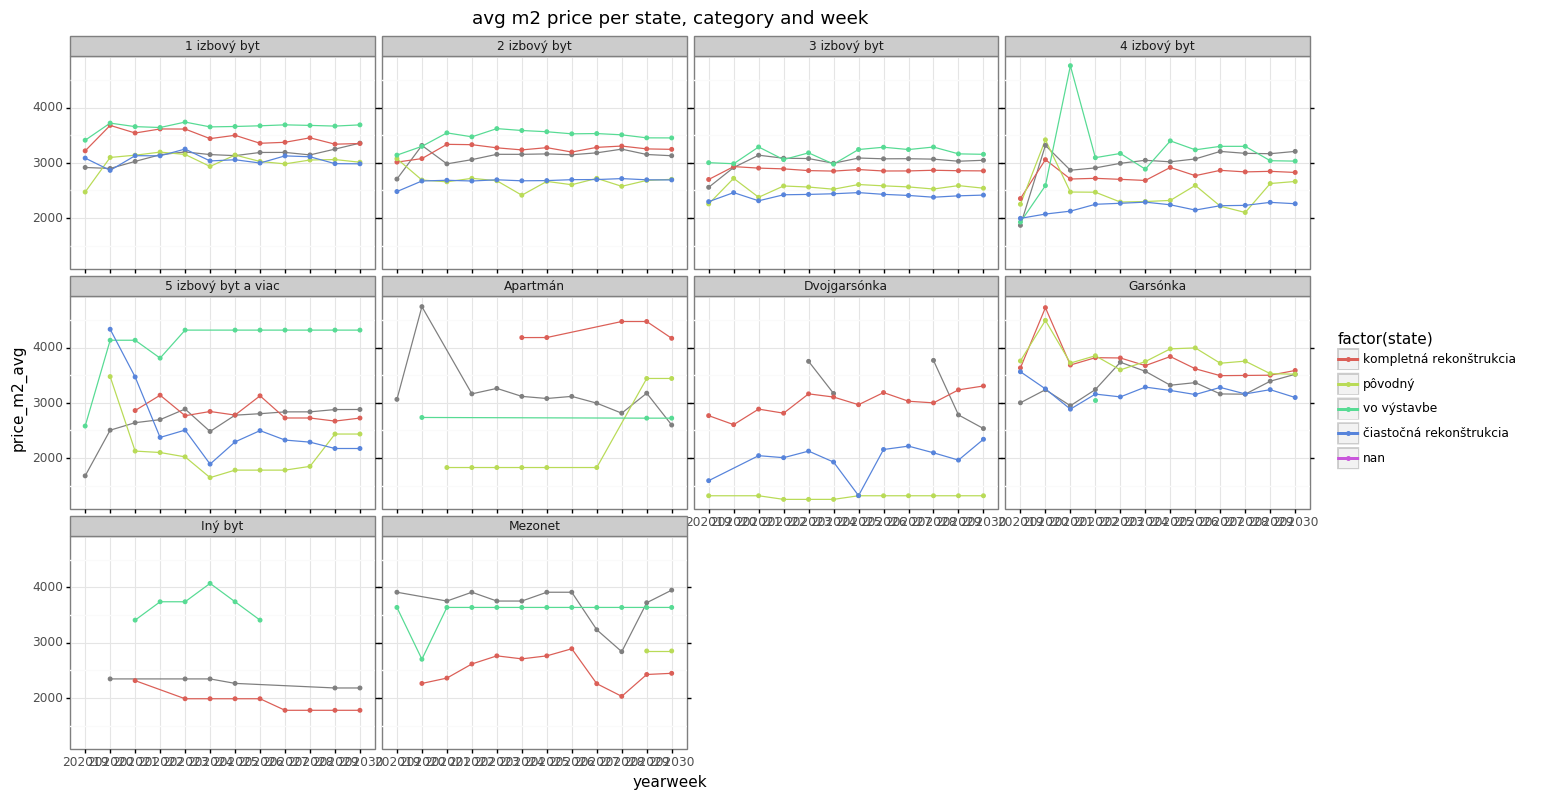

<ggplot: (-9223371870580009724)>


In [94]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg m2 price per state, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [95]:
df20.style.format("{:.0f}", na_rep = '-')

In [96]:
q19 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df19 = pd.json_normalize(q19)\
    .rename(columns = {'_id.state':'state', '_id.category':'category'})\
    .sort_values(['state', 'price_m2_avg'], ascending = False)
df19 = df19[['state', 'category', 'price_m2_avg', 'ads_count']]
df19 = df19.pivot(index = 'state', columns = 'category', values = 'price_m2_avg')
df19.style.format("{:.0f}", na_rep = '-')

## avg m2 price per state and location

In [97]:
q20 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.yearweek':'yearweek'})
df20 = df20[['location', 'state', 'yearweek', 'price_m2_avg']]
df21 = df20.loc[df20['location'].isin(locs),:].pivot_table(index = ['state', 'location'], columns = 'yearweek', values = 'price_m2_avg')

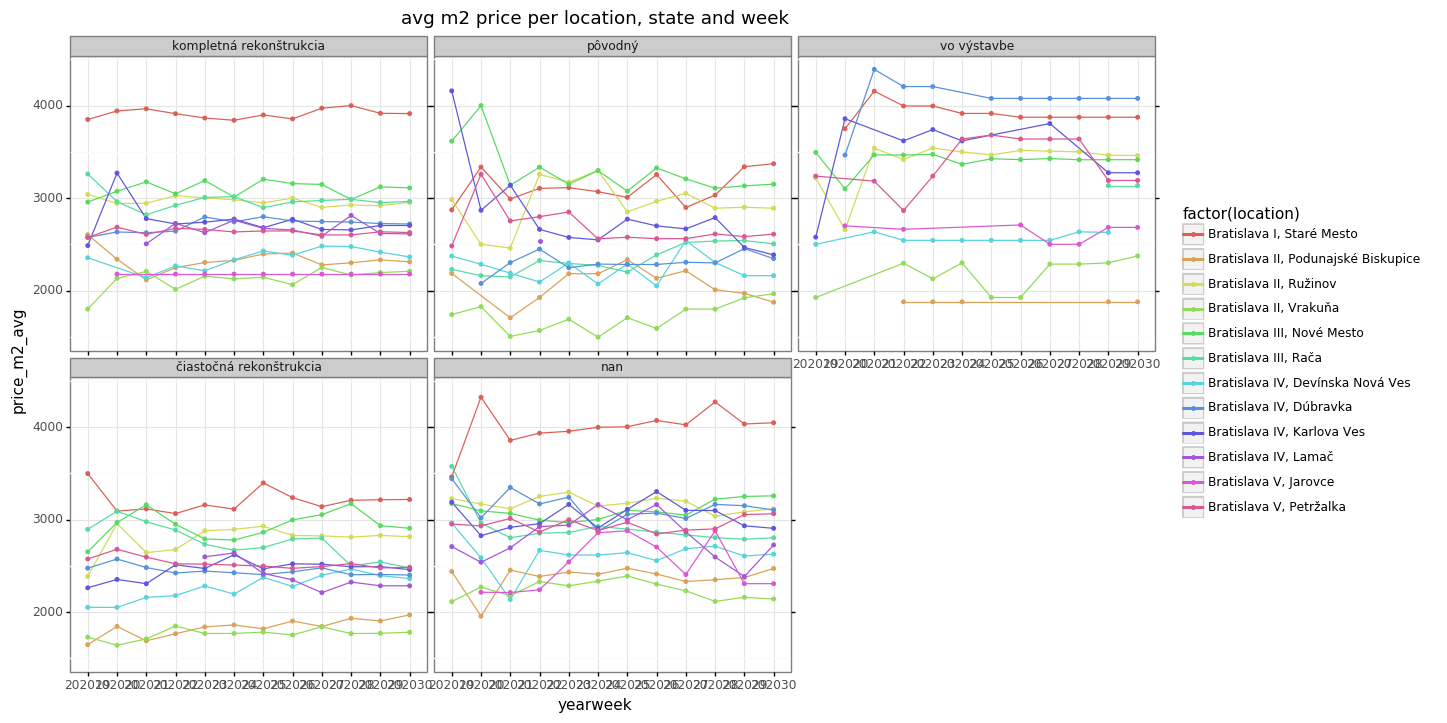

<ggplot: (-9223371870579334488)>


In [98]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df20.loc[df20['location'].isin(locs),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg m2 price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

In [99]:
df21.style.format("{:.0f}", na_rep = '-')

In [100]:
q20 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state'})\
    .sort_values('price_m2_avg', ascending = False)
df20 = df20[['location', 'state', 'price_m2_avg', 'ads_count']]
df20 = df20.loc[df20['location'].isin(locs),:].pivot(index = 'location', columns = 'state', values = 'price_m2_avg')
df20.style.format("{:.0f}", na_rep = '-')

## avg m2 price per state, location and category

In [101]:
q21 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek': '$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}  
  }
	
]))
	
df21 = pd.json_normalize(q21)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category', '_id.yearweek':'yearweek'})
df22 = df21.loc[df21['location'].isin(locs),:].pivot_table(index = ['category', 'state', 'location'], columns = 'yearweek', values = 'price_m2_avg')
df22.style.format("{:.0f}", na_rep = '-')

In [102]:
q22 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df22 = pd.json_normalize(q22)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category'})\
    .sort_values('price_m2_avg', ascending = False)
df22 = df22.loc[df22['location'].isin(locs),:].pivot_table(index = ['location', 'category'], columns = 'state', values = ['price_m2_avg', 'ads_count'])
df22.columns = df22.columns.swaplevel(0, 1)
df22.sort_index(axis=1, level=0, inplace=True)
df22.style.format("{:.0f}", na_rep = '-')

### 2 room apartment

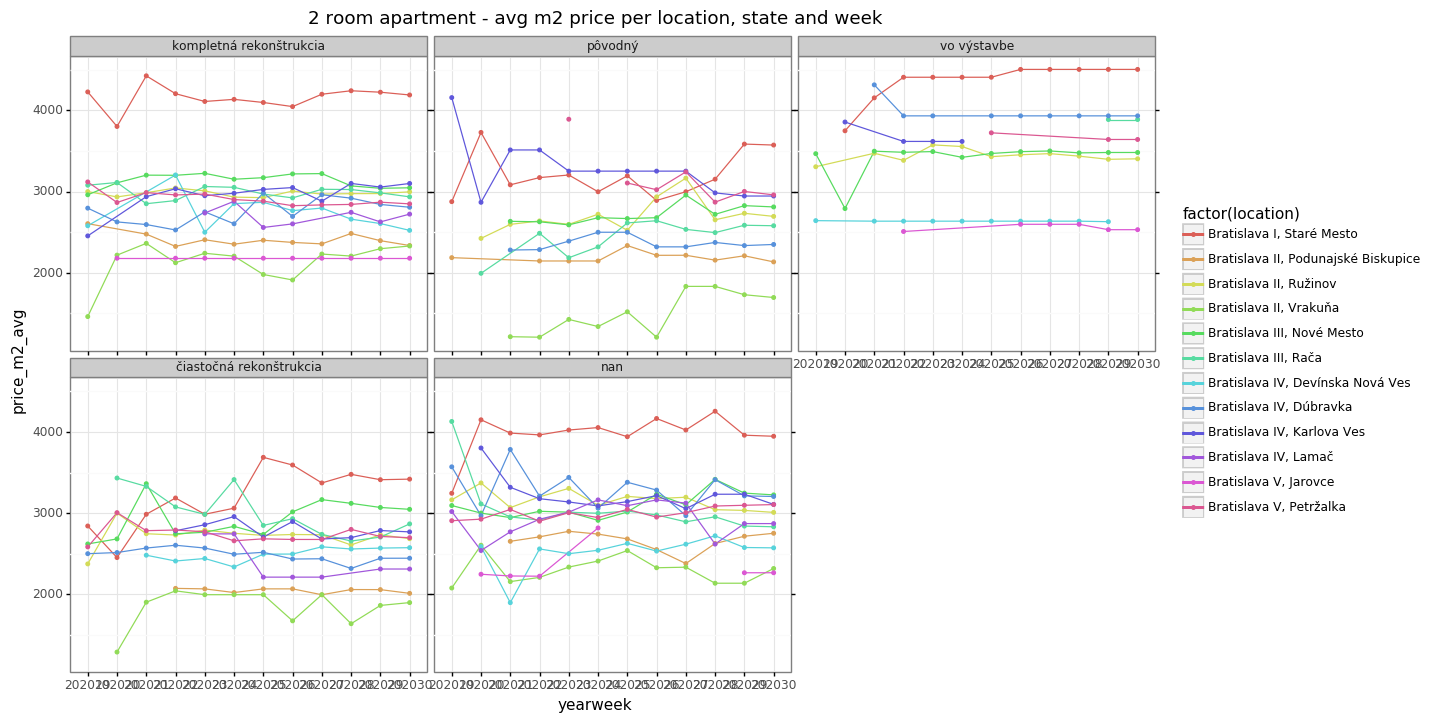

<ggplot: (-9223371870580128396)>


In [103]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '2 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '2 room apartment - avg m2 price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

### 3 room apartment

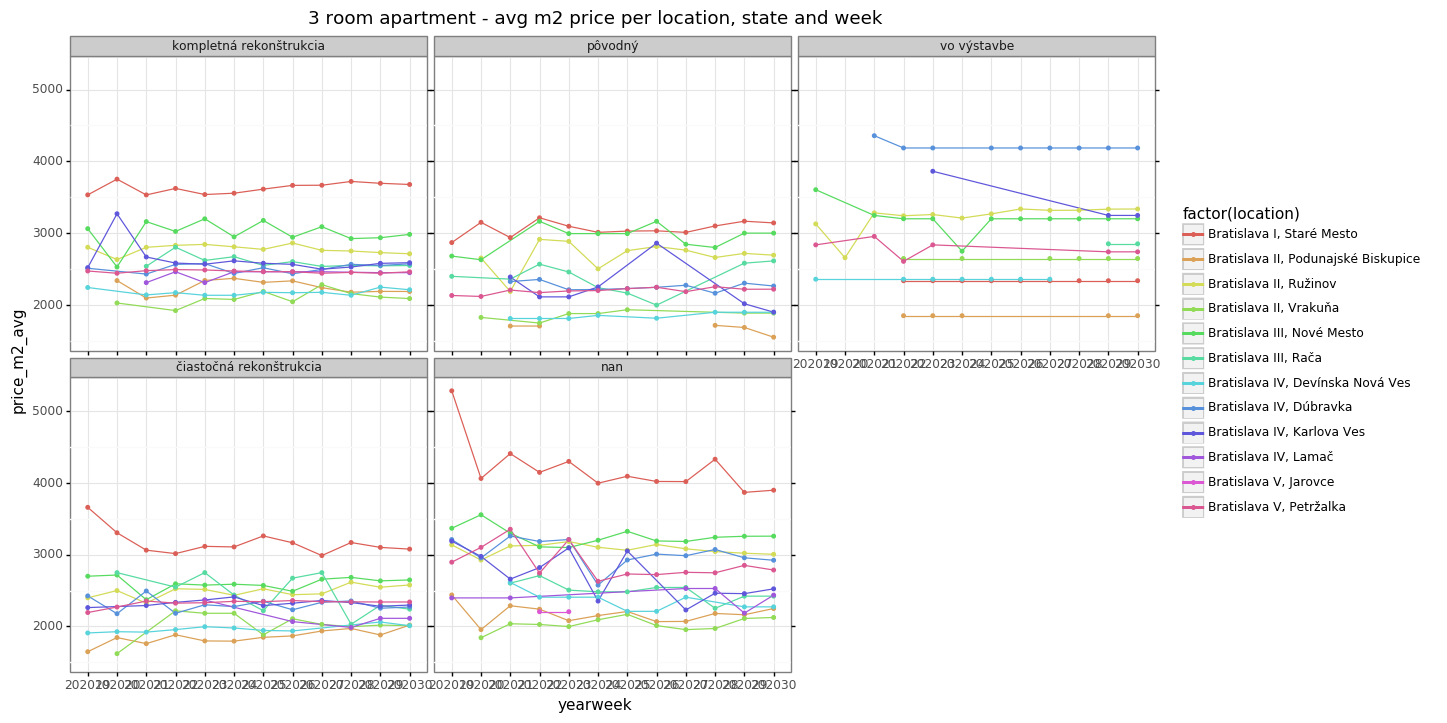

<ggplot: (-9223371870580097180)>


In [104]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '3 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '3 room apartment - avg m2 price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

# DISTRIBUTION SELECTED CHARTS

# PRICE

In [105]:
q_all = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties.Cena':1, 'properties.Lokalita':1, 'properties.Stav':1, 'properties.Stav nehnuteľnosti:':1, 'properties.Kategória':1, 'properties.Cena za meter':1}
    }
	
]))
	
df_all = pd.json_normalize(q_all)\
    .rename(columns = {'properties.Cena':'price', 'properties.Lokalita':'location', 
                       'properties.Stav':'state', 'properties.Stav nehnuteľnosti:':'property_state', 
                       'properties.Kategória':'category', 'properties.Cena za meter':'price_m2'})
df_all.head()

_id yearweek     price  \
0  5f1d75dea8b819bb618f7874   202030  266000.0   
1  5f1d67d8a8b819bb618f73ba   202030  118500.0   
2  5f1d8f24a8b819bb618f80cc   202030  131600.0   
3  5f1da824a8b819bb618f8836   202030  650000.0   
4  5f1d967ea8b819bb618f8316   202030  480000.0   

                           location property_state             category  \
0        Bratislava III, Nové Mesto     Novostavba         4 izbový byt   
1  Bratislava IV, Devínska Nová Ves     Novostavba         1 izbový byt   
2              Bratislava III, Rača     Novostavba         1 izbový byt   
3         Bratislava I, Staré Mesto     Novostavba         3 izbový byt   
4         Bratislava I, Staré Mesto     Novostavba  5 izbový byt a viac   

   price_m2    state  
0    2767.0      NaN  
1    2963.0      NaN  
2    3096.0      NaN  
3    4333.0      NaN  
4    3000.0  pôvodný

## overal histogram

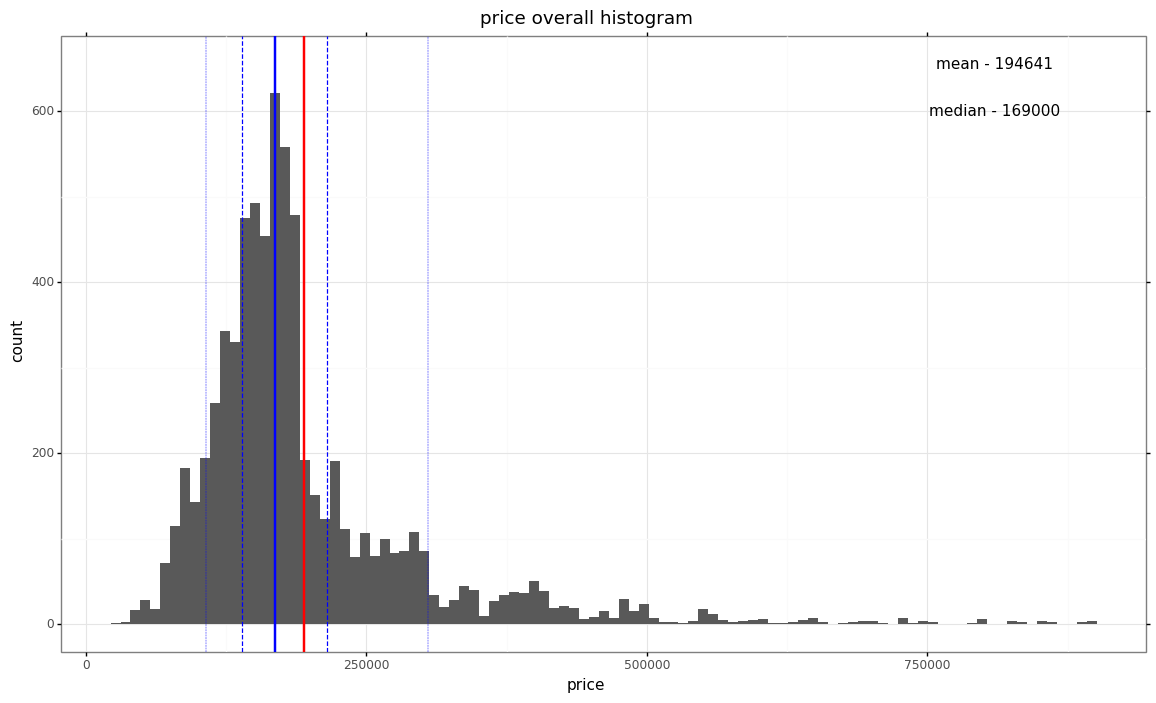

<ggplot: (-9223371870578000444)>


In [106]:
p = (ggplot(aes(x = 'price'), 
            data = df_all)
    + geom_histogram()
    + geom_vline(aes(xintercept = 'price.mean()'), color = 'red', size = 1)
    + geom_vline(aes(xintercept = 'price.median()'), color = 'blue', size = 1)
    + geom_vline(aes(xintercept = 'price.quantile(0.25)'), color = 'blue', linetype = 'dashed')
    + geom_vline(aes(xintercept = 'price.quantile(0.75)'), color = 'blue', linetype = 'dashed')
    + geom_vline(aes(xintercept = 'price.quantile(0.1)'), color = 'blue', linetype = 'dashed', size = 0.2)
    + geom_vline(aes(xintercept = 'price.quantile(0.9)'), color = 'blue', linetype = 'dashed', size = 0.2)
    + annotate('text', x=0.9*df_all['price'].max(), y = len(df_all)/11, label=f"mean - {int(df_all.price.mean())}")
    + annotate('text', x=0.9*df_all['price'].max(), y = len(df_all)/12, label=f"median - {int(df_all.price.median())}")
    + labs(title = 'price overall histogram')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

In [107]:
def q10(x):
    return x.quantile(0.1)
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)
def q90(x):
    return x.quantile(0.9)

df_all_yw =  df_all.groupby('yearweek', as_index = False)\
    .agg({'price':[q10, q25, 'median', 'mean', q75, q90]})
df_all_yw.columns = ['yearweek', 'q10', 'q25', 'median', 'mean', 'q75', 'q90']
df_all_yw = df_all_yw.melt(id_vars = 'yearweek')
df_all_yw.columns = ['yearweek', 'metric', 'price']
df_all_yw.head()

yearweek metric     price
0   202019    q10   91530.0
1   202020    q10  104998.0
2   202021    q10   96000.0
3   202022    q10  103194.0
4   202023    q10  114990.0

## overall - ts

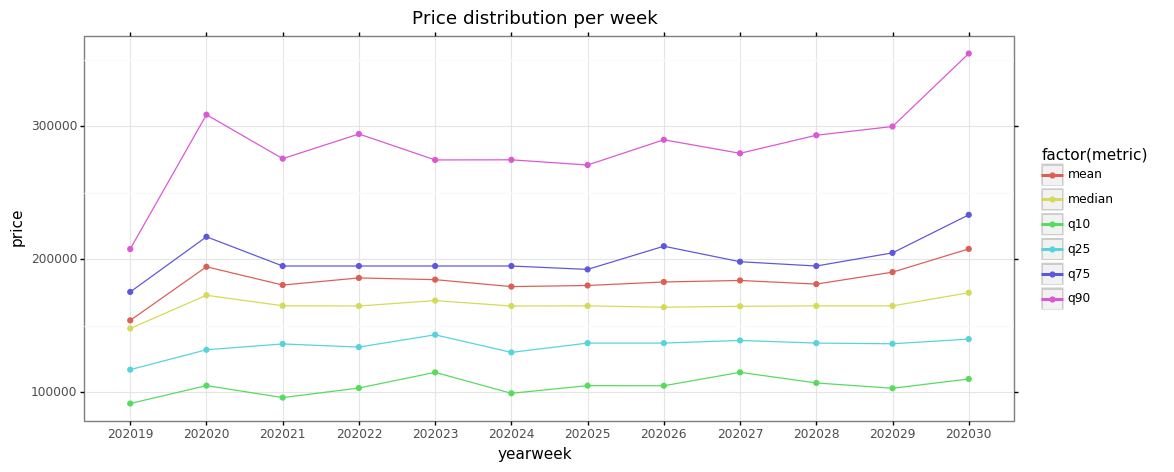

<ggplot: (-9223371870577906476)>


In [108]:
p = (ggplot(aes(x = 'yearweek', y = 'price', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw)
    + geom_line()
    + geom_point()
    + labs(title = 'Price distribution per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

##  per state, location and category

### 2 room apartment

In [109]:
df_all_yw =  df_all.groupby(['yearweek', 'location', 'state', 'category'], as_index = False)\
    .agg({'price':[q10, q25, 'median', 'mean', q75, q90]})
df_all_yw.columns = ['yearweek', 'location', 'state', 'category','q10', 'q25', 'median', 'mean', 'q75', 'q90']
df_all_yw = df_all_yw.melt(id_vars = ['yearweek', 'location', 'state', 'category'])
df_all_yw.columns = ['yearweek', 'location', 'state', 'category', 'metric', 'price']
df_all_yw.head()

yearweek                   location                    state      category  \
0   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  1 izbový byt   
1   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  2 izbový byt   
2   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  3 izbový byt   
3   202019  Bratislava I, Staré Mesto                  pôvodný  3 izbový byt   
4   202019  Bratislava I, Staré Mesto  čiastočná rekonštrukcia  2 izbový byt   

  metric     price  
0    q10  179300.0  
1    q10  191145.0  
2    q10  285899.1  
3    q10  310000.0  
4    q10  196000.0

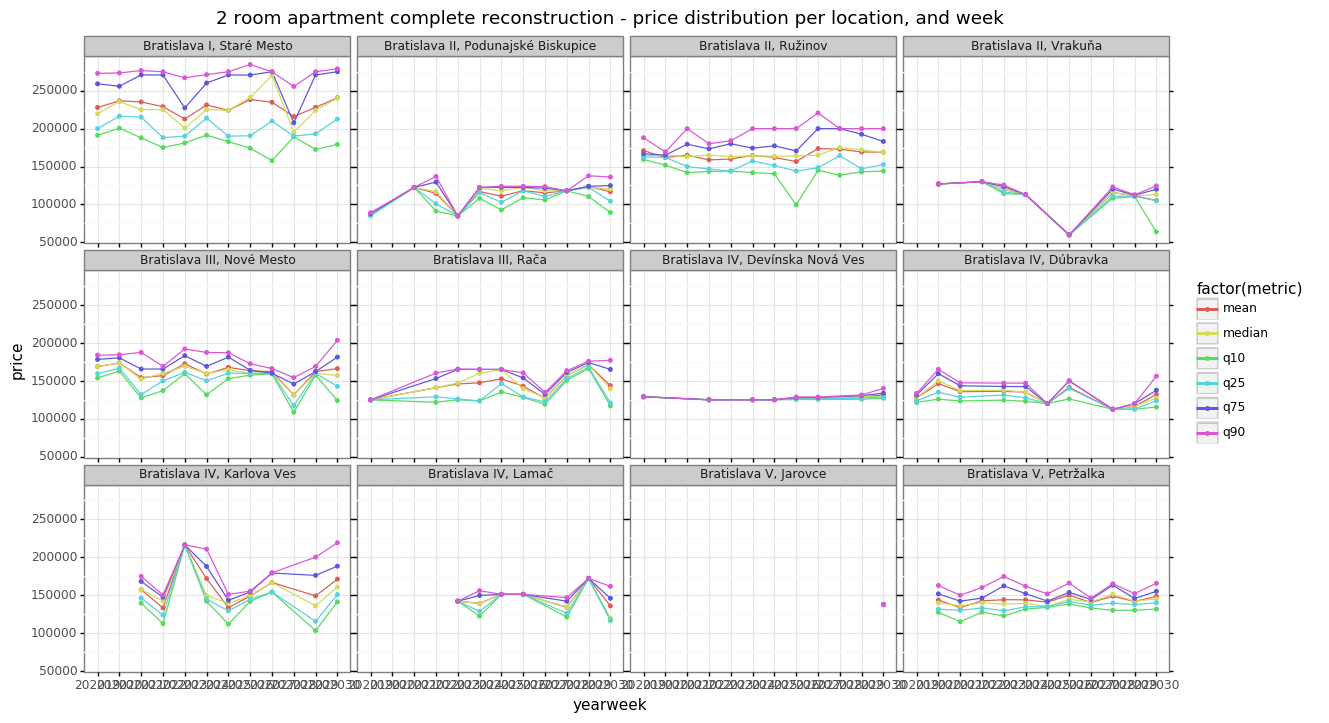

<ggplot: (-9223371870577806864)>


In [110]:
p = (ggplot(aes(x = 'yearweek', y = 'price', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw.loc[(df_all_yw['category']== '2 izbový byt') & (df_all_yw['location'].isin(locs)) & (df_all_yw['state'] == 'kompletná rekonštrukcia'),:])
    + facet_wrap('location')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '2 room apartment complete reconstruction - price distribution per location, and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

### 3 room apartment

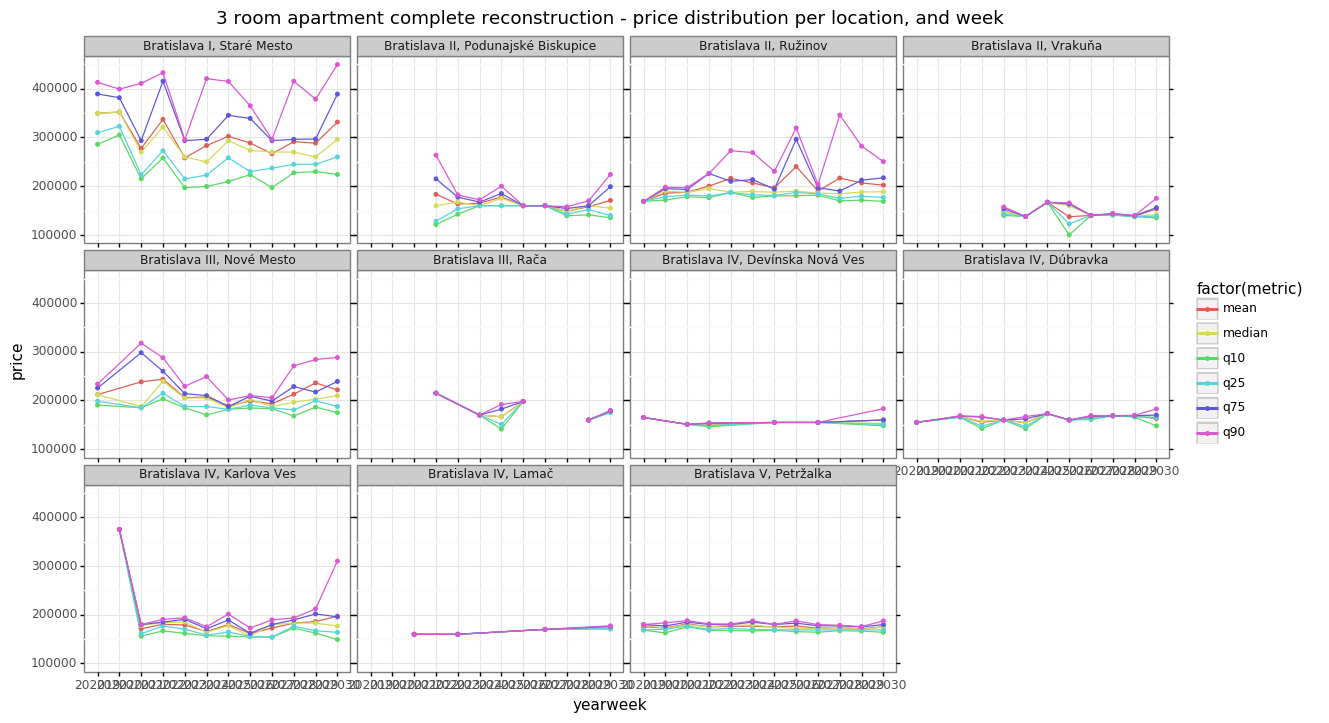

<ggplot: (-9223371870577927812)>


In [111]:
p = (ggplot(aes(x = 'yearweek', y = 'price', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw.loc[(df_all_yw['category']== '3 izbový byt') & (df_all_yw['location'].isin(locs)) & (df_all_yw['state'] == 'kompletná rekonštrukcia'),:])
    + facet_wrap('location')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '3 room apartment complete reconstruction - price distribution per location, and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

# M2 PRICE

## overal histogram

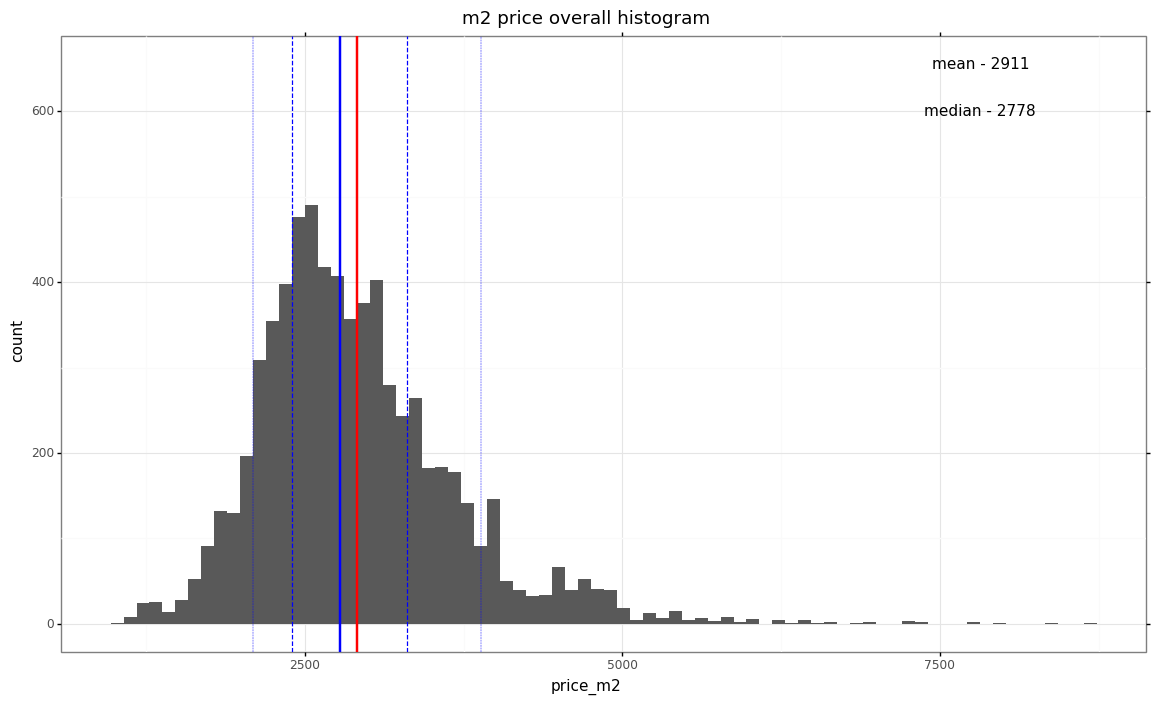

<ggplot: (-9223371870579541420)>


In [112]:
p = (ggplot(aes(x = 'price_m2'), 
            data = df_all)
    + geom_histogram()
    + geom_vline(aes(xintercept = 'price_m2.mean()'), color = 'red', size = 1)
    + geom_vline(aes(xintercept = 'price_m2.median()'), color = 'blue', size = 1)
    + geom_vline(aes(xintercept = 'price_m2.quantile(0.25)'), color = 'blue', linetype = 'dashed')
    + geom_vline(aes(xintercept = 'price_m2.quantile(0.75)'), color = 'blue', linetype = 'dashed')
    + geom_vline(aes(xintercept = 'price_m2.quantile(0.1)'), color = 'blue', linetype = 'dashed', size = 0.2)
    + geom_vline(aes(xintercept = 'price_m2.quantile(0.9)'), color = 'blue', linetype = 'dashed', size = 0.2)
    + annotate('text', x=0.9*df_all['price_m2'].max(), y = len(df_all)/11, label=f"mean - {int(df_all.price_m2.mean())}")
    + annotate('text', x=0.9*df_all['price_m2'].max(), y = len(df_all)/12, label=f"median - {int(df_all.price_m2.median())}")
    + labs(title = 'm2 price overall histogram')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

In [113]:
def q10(x):
    return x.quantile(0.1)
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)
def q90(x):
    return x.quantile(0.9)

df_all_yw =  df_all.groupby('yearweek', as_index = False)\
    .agg({'price_m2':[q10, q25, 'median', 'mean', q75, q90]})
df_all_yw.columns = ['yearweek', 'q10', 'q25', 'median', 'mean', 'q75', 'q90']
df_all_yw = df_all_yw.melt(id_vars = 'yearweek')
df_all_yw.columns = ['yearweek', 'metric', 'price_m2']
df_all_yw.head()

yearweek metric  price_m2
0   202019    q10    1579.8
1   202020    q10    2261.2
2   202021    q10    2123.8
3   202022    q10    2057.6
4   202023    q10    2184.0

## overall - ts

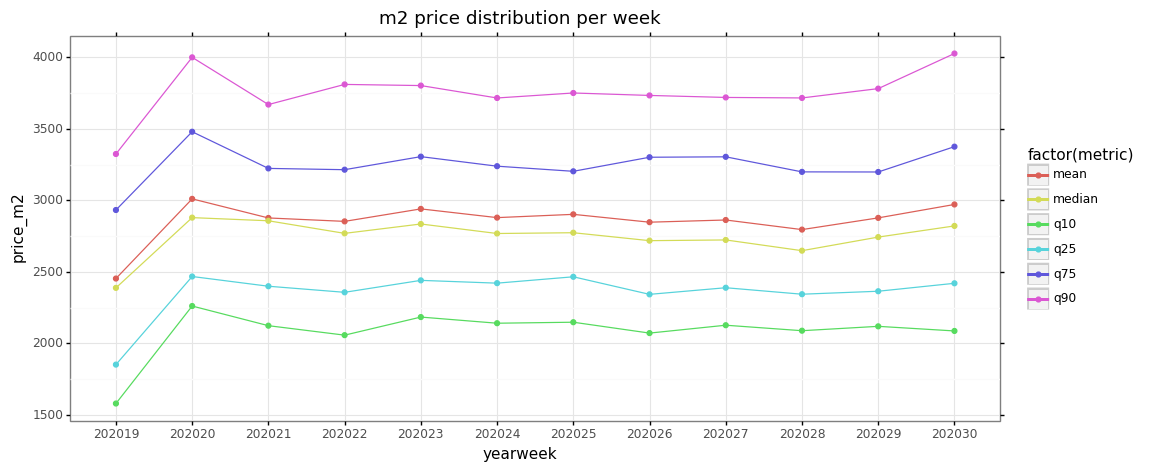

<ggplot: (-9223371870577457460)>


In [114]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw)
    + geom_line()
    + geom_point()
    + labs(title = 'm2 price distribution per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

##  per state, location and category

### 2 room apartment

In [115]:
df_all_yw =  df_all.groupby(['yearweek', 'location', 'state', 'category'], as_index = False)\
    .agg({'price_m2':[q10, q25, 'median', 'mean', q75, q90]})
df_all_yw.columns = ['yearweek', 'location', 'state', 'category','q10', 'q25', 'median', 'mean', 'q75', 'q90']
df_all_yw = df_all_yw.melt(id_vars = ['yearweek', 'location', 'state', 'category'])
df_all_yw.columns = ['yearweek', 'location', 'state', 'category', 'metric', 'price_m2']
df_all_yw.head()

yearweek                   location                    state      category  \
0   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  1 izbový byt   
1   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  2 izbový byt   
2   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  3 izbový byt   
3   202019  Bratislava I, Staré Mesto                  pôvodný  3 izbový byt   
4   202019  Bratislava I, Staré Mesto  čiastočná rekonštrukcia  2 izbový byt   

  metric  price_m2  
0    q10    4718.0  
1    q10    3353.5  
2    q10    3355.7  
3    q10    2870.0  
4    q10    2841.0

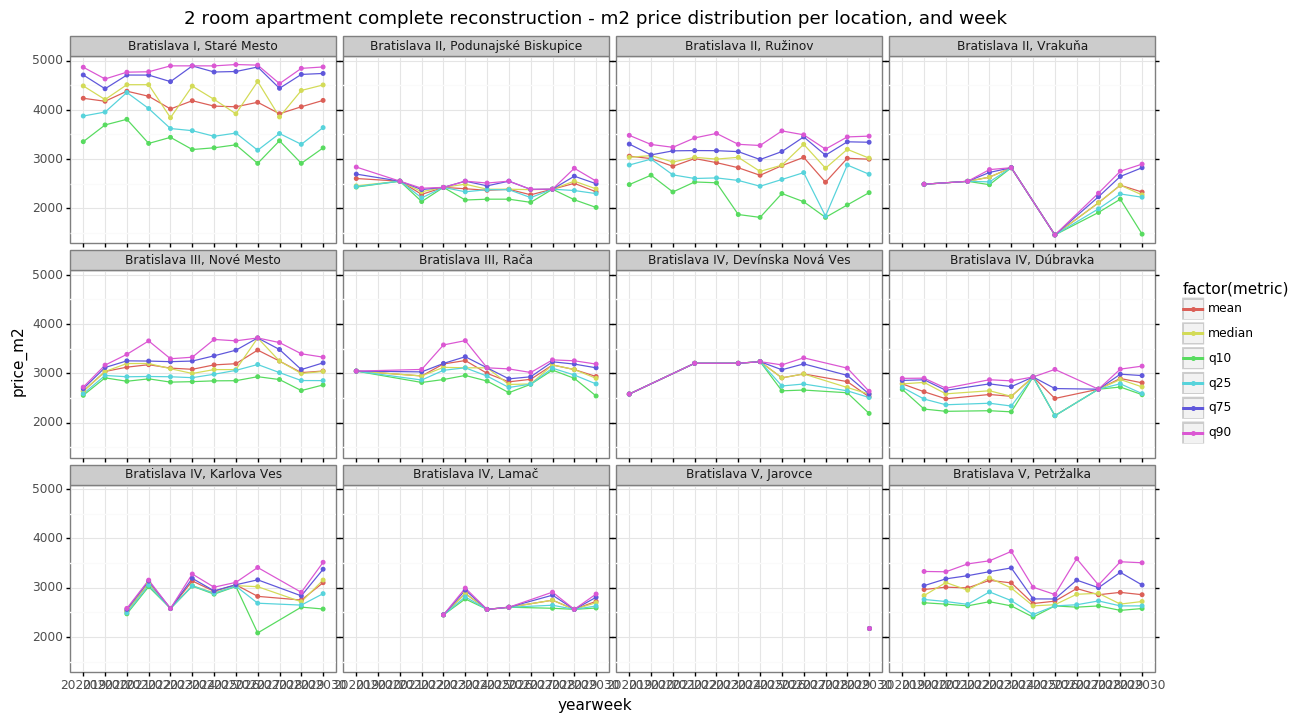

<ggplot: (-9223371870575643436)>


In [116]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw.loc[(df_all_yw['category']== '2 izbový byt') & (df_all_yw['location'].isin(locs)) & (df_all_yw['state'] == 'kompletná rekonštrukcia'),:])
    + facet_wrap('location')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '2 room apartment complete reconstruction - m2 price distribution per location, and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

### 3 room apartment

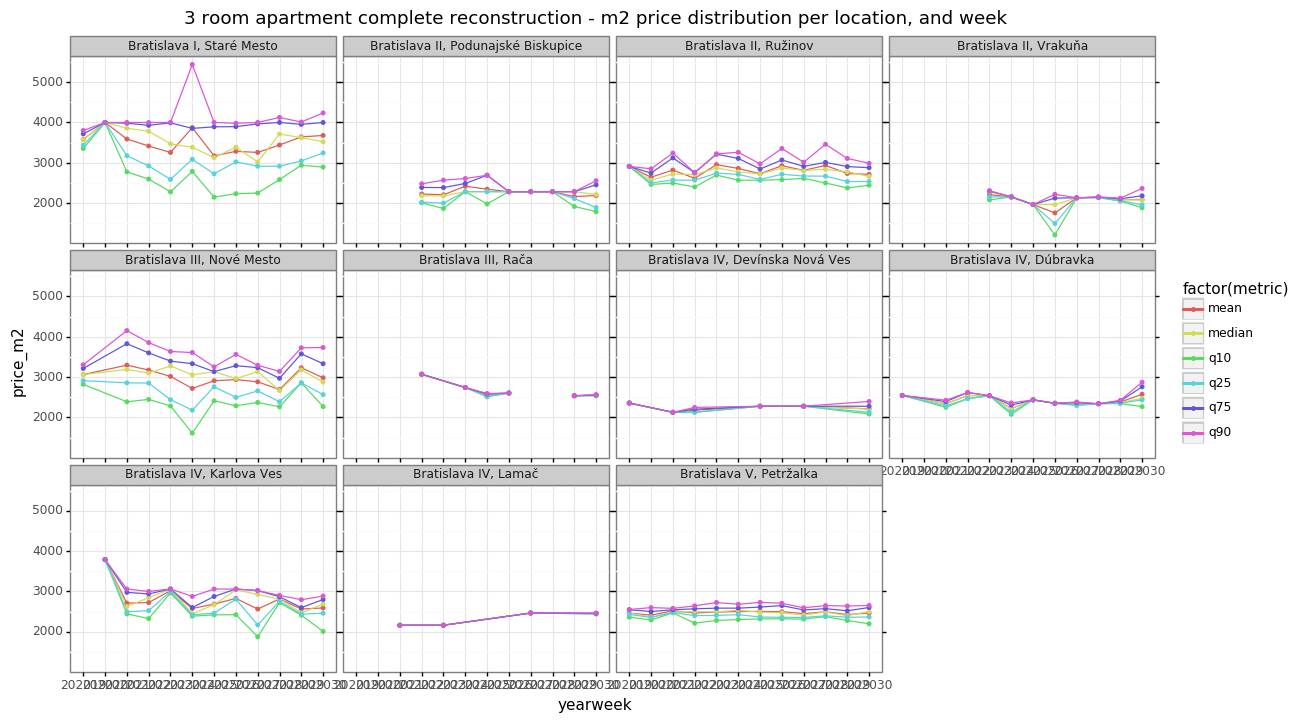

<ggplot: (-9223371870581656592)>


In [117]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw.loc[(df_all_yw['category']== '3 izbový byt') & (df_all_yw['location'].isin(locs)) & (df_all_yw['state'] == 'kompletná rekonštrukcia'),:])
    + facet_wrap('location')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '3 room apartment complete reconstruction - m2 price distribution per location, and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

# TODO

- check properties.Stav vs properties.Stav nehnuteľnosti
- add to distribution section povodny stav charts 2 and 3 room apartments
- add charts % growth of medians
- % of new ads each week
- monthly report